In [7]:
import pandas as pd
from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
from utils.general import check_missing_timestamps

import ccxt 


def get_exchange_timeframes(exchange_id):
    """
    Get the list of available timeframes for a given exchange.

    Args:
        exchange_id (str): The exchange ID (e.g., "binance", "bitget").

    Returns:
        list: A list of available timeframes for the exchange.
    """
    try:
        # Initialize the exchange
        exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True})

        # Check if the exchange supports timeframes
        if hasattr(exchange, 'timeframes') and exchange.timeframes:
            return list(exchange.timeframes.keys())
        else:
            return []
    except Exception as e:
        print(f"Error fetching timeframes for {exchange_id}: {e}")
        return []

# Example Usage
exchange_id = "bitget"  # Replace with your desired exchange ID
timeframes = get_exchange_timeframes(exchange_id)
print(f"Available timeframes for {exchange_id}: {timeframes}")

Available timeframes for bitget: ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '12h', '1d', '3d', '1w', '1M']


In [20]:
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/VET_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
missing = check_missing_timestamps(df, freq='1min')
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,volume
date,,,,,
2024-01-01 12:22:00,0.03452,0.03458,0.03452,0.03458,12248.0
2024-01-01 12:23:00,0.03458,0.03461,0.03457,0.03457,57838.0
2024-01-01 12:24:00,0.03457,0.03460,0.03457,0.03459,7702.0
2024-01-01 12:25:00,0.03459,0.03459,0.03454,0.03458,4597.0
2024-01-01 12:26:00,0.03458,0.03462,0.03458,0.03461,1676.0


In [21]:
# import plotly.graph_objects as go
# # Create a candlestick chart using Plotly
# fig = go.Figure(data=[go.Candlestick(
#     x=df.index,
#     open=df['open'],
#     high=df['high'],
#     low=df['low'],
#     close=df['close'],
#     increasing_line_color='green',  # Green for price increase
#     decreasing_line_color='red',    # Red for price decrease
# )])
# # Customize layout
# fig.update_layout(
#     title='',
#     xaxis_title='Date',
#     yaxis_title='Price (USDT)',
#     template='plotly_dark',  # Set a dark theme for the plot
#     xaxis_rangeslider_visible=False  # Optionally hide the range slider
# )
# # Show the plot
# fig.show()

## Candle Wick Analysis

- Count the number of Candle that upper wick > 0 and upper wick = 0 
- Make the ratio of upper wick higher than zero and equal to zero.
- Perform the same analysis for each timeframe
- Perform the the upper average in [%] during different market period: American / Europe / Asian (week end not included)

In [22]:
df_tmp = df.resample('5min').agg({
    'open': 'first',     # First price in the 1-hour window (Open)
    'high': 'max',       # Maximum price in the 1-hour window (High)
    'low': 'min',        # Minimum price in the 1-hour window (Low)
    'close': 'last',     # Last price in the 1-hour window (Close)
    'volume': 'sum'      # Total volume in the 1-hour window
})
df_tmp.head()

,open,high,low,close,volume
date,,,,,
2024-01-01 12:20:00,0.03452,0.03461,0.03452,0.03459,77788.0
2024-01-01 12:25:00,0.03459,0.03462,0.03454,0.03460,13952.0
2024-01-01 12:30:00,0.03460,0.03462,0.03457,0.03459,50897.0
2024-01-01 12:35:00,0.03459,0.03469,0.03459,0.03465,170248.0
2024-01-01 12:40:00,0.03465,0.03476,0.03465,0.03474,39070.0


In [23]:
df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)

# Count the days where the wick is greater than zero
upper_wick_count = df[df['upper_wick'] > 0].shape[0]
neutral_wick_count = df[df['upper_wick'] == 0].shape[0]

total_candles = len(df)
upper_wick_percentage = upper_wick_count * 100 / total_candles
neutral_wick_percentage = neutral_wick_count * 100 / total_candles

print(f"Total Number of candles: {total_candles}")
print(f"Number of upper wick > 0 : {upper_wick_count} -- {upper_wick_percentage:.2f}%")
print(f"Number of neutral wick == 0 : {neutral_wick_count} -- {neutral_wick_percentage:.2f}%")

Total Number of candles: 533200
Number of upper wick > 0 : 250092 -- 46.90%
Number of neutral wick == 0 : 283108 -- 53.10%


### Analysis for all timeframe

In [24]:
# Mapping of timeframes to pandas resampling strings
timeframe_resampling_map = {
    '1m': '1min',   # 1 minute
    '3m': '3min',   # 3 minutes
    '5m': '5min',   # 5 minutes
    '15m': '15min', # 15 minutes
    '30m': '30min', # 30 minutes
    '1h': '1h',   # 1 hour
    '2h': '2h',   # 2 hours
    '4h': '4h',   # 4 hours
}

In [25]:
results = {}

for timeframe, resample_str in timeframe_resampling_map.items():
    # Resample the DataFrame
    df_resampled = df.resample(resample_str).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    # Calculate the upper wick
    df_resampled['upper_wick'] = df_resampled['high'] - df_resampled[['open', 'close']].max(axis=1)

    # Perform analysis
    total_candles = len(df_resampled)
    upper_wick_count = df_resampled[df_resampled['upper_wick'] > 0].shape[0]
    neutral_wick_count = df_resampled[df_resampled['upper_wick'] == 0].shape[0]

    upper_wick_percentage = upper_wick_count * 100 / total_candles if total_candles > 0 else 0
    neutral_wick_percentage = neutral_wick_count * 100 / total_candles if total_candles > 0 else 0

    # Store results
    results[timeframe] = {
        'total_candles': total_candles,
        'upper_wick_count': upper_wick_count,
        'neutral_wick_count': neutral_wick_count,
        'upper_wick_percentage': round(upper_wick_percentage, 2),
        'neutral_wick_percentage': round(neutral_wick_percentage, 2)
    }

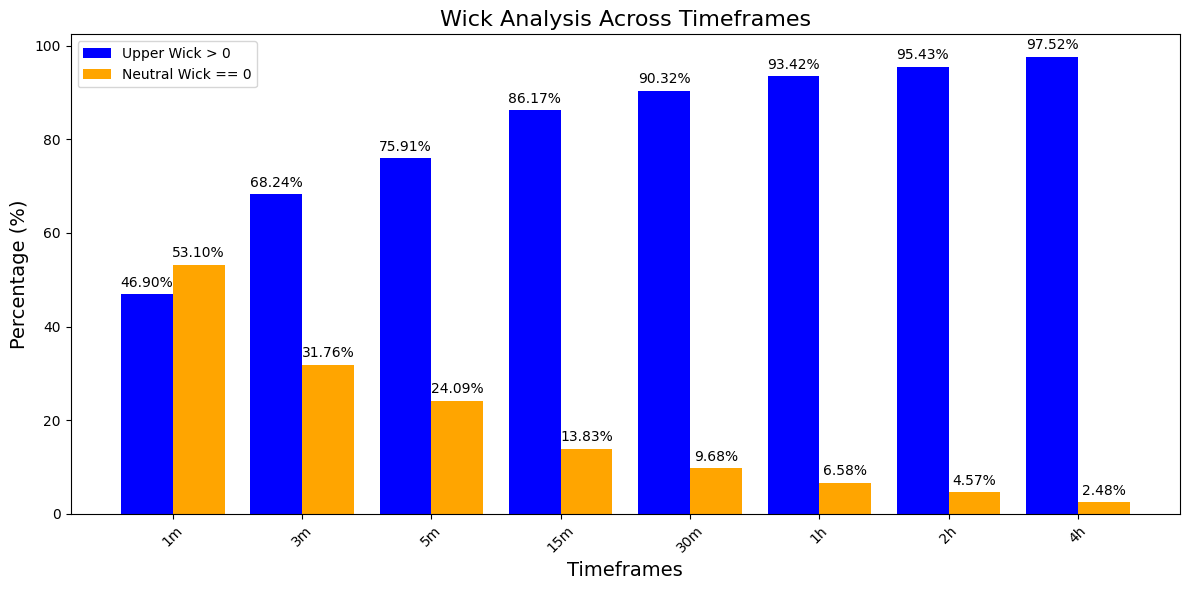

In [26]:
import matplotlib.pyplot as plt

# Prepare data for plotting
timeframes = list(results.keys())
upper_wick_percentages = [stats['upper_wick_percentage'] for stats in results.values()]
neutral_wick_percentages = [stats['neutral_wick_percentage'] for stats in results.values()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.4

# Plot upper wick percentages
ax.bar([i - bar_width / 2 for i in range(len(timeframes))], upper_wick_percentages, 
       width=bar_width, label='Upper Wick > 0', color='blue')

# Plot neutral wick percentages
ax.bar([i + bar_width / 2 for i in range(len(timeframes))], neutral_wick_percentages, 
       width=bar_width, label='Neutral Wick == 0', color='orange')

# Formatting
ax.set_title('Wick Analysis Across Timeframes', fontsize=16)
ax.set_xlabel('Timeframes', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks(range(len(timeframes)))
ax.set_xticklabels(timeframes, rotation=45)
ax.legend()

# Add percentage labels on bars
for i, (upper, neutral) in enumerate(zip(upper_wick_percentages, neutral_wick_percentages)):
    ax.text(i - bar_width / 2, upper + 1, f'{upper:.2f}%', ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width / 2, neutral + 1, f'{neutral:.2f}%', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

In [39]:
# Function to calculate wick statistics
def calculate_wick_statistics(df, timeframe_resampling_map):
    """
    Calculate wick statistics for a DataFrame across multiple timeframes.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'open', 'high', 'low', 'close', 'volume'.
        timeframe_resampling_map (dict): Mapping of timeframes to pandas resampling strings.

    Returns:
        dict: Wick statistics for each timeframe.
    """
    results = {}

    for timeframe, resample_str in timeframe_resampling_map.items():
        # Resample the DataFrame
        df_resampled = df.resample(resample_str).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }).dropna()

        # Calculate the upper wick
        df_resampled['upper_wick'] = df_resampled['high'] - df_resampled[['open', 'close']].max(axis=1)

        # Perform analysis
        total_candles = len(df_resampled)
        upper_wick_count = df_resampled[df_resampled['upper_wick'] > 0].shape[0]
        neutral_wick_count = df_resampled[df_resampled['upper_wick'] == 0].shape[0]

        upper_wick_percentage = upper_wick_count * 100 / total_candles if total_candles > 0 else 0
        neutral_wick_percentage = neutral_wick_count * 100 / total_candles if total_candles > 0 else 0

        # Store results
        results[timeframe] = {
            'total_candles': total_candles,
            'upper_wick_count': upper_wick_count,
            'neutral_wick_count': neutral_wick_count,
            'upper_wick_percentage': round(upper_wick_percentage, 2),
            'neutral_wick_percentage': round(neutral_wick_percentage, 2)
        }

    return results

# Function to plot wick statistics
def plot_wick_statistics(results, crypto_name):
    """
    Plot wick statistics across timeframes.

    Parameters:
        results (dict): Wick statistics for each timeframe.
        crypto_name (str): Name of the cryptocurrency.
    """
    # Prepare data for plotting
    timeframes = list(results.keys())
    upper_wick_percentages = [stats['upper_wick_percentage'] for stats in results.values()]
    neutral_wick_percentages = [stats['neutral_wick_percentage'] for stats in results.values()]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Bar width
    bar_width = 0.4

    # Plot upper wick percentages
    ax.bar([i - bar_width / 2 for i in range(len(timeframes))], upper_wick_percentages, 
           width=bar_width, label='Upper Wick > 0', color='blue')

    # Plot neutral wick percentages
    ax.bar([i + bar_width / 2 for i in range(len(timeframes))], neutral_wick_percentages, 
           width=bar_width, label='Neutral Wick == 0', color='orange')

    # Formatting
    ax.set_title(f'Wick Analysis Across Timeframes for {crypto_name}', fontsize=16)
    ax.set_xlabel('Timeframes', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_xticks(range(len(timeframes)))
    ax.set_xticklabels(timeframes, rotation=45)
    ax.legend()

    # Add percentage labels on bars
    for i, (upper, neutral) in enumerate(zip(upper_wick_percentages, neutral_wick_percentages)):
        ax.text(i - bar_width / 2, upper + 1, f'{upper:.2f}%', ha='center', va='bottom', fontsize=10)
        ax.text(i + bar_width / 2, neutral + 1, f'{neutral:.2f}%', ha='center', va='bottom', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()



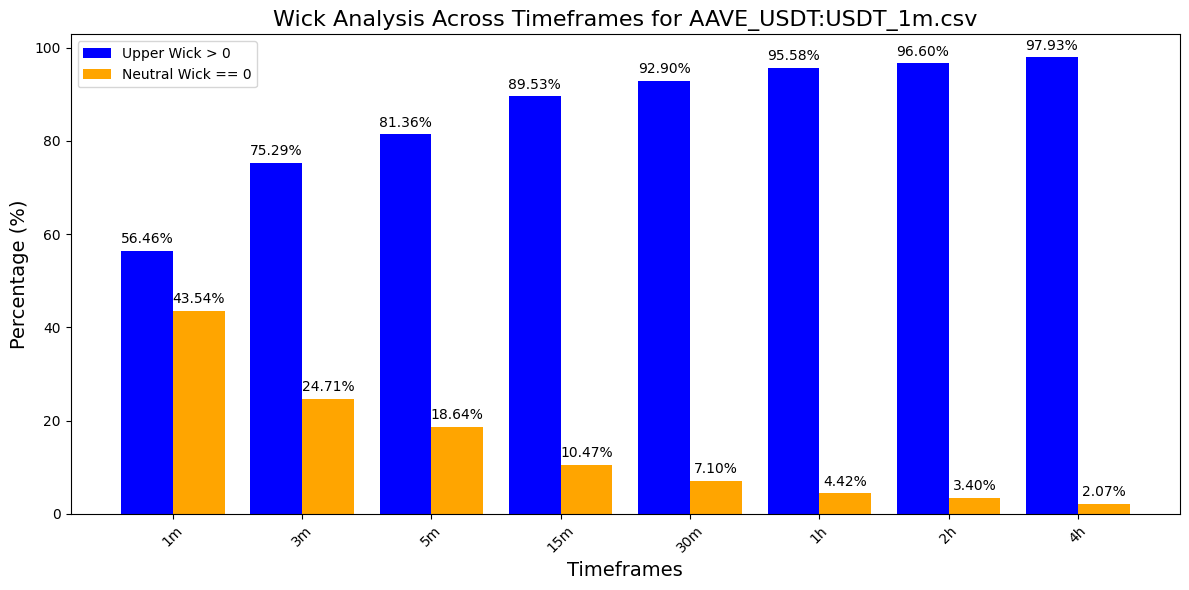

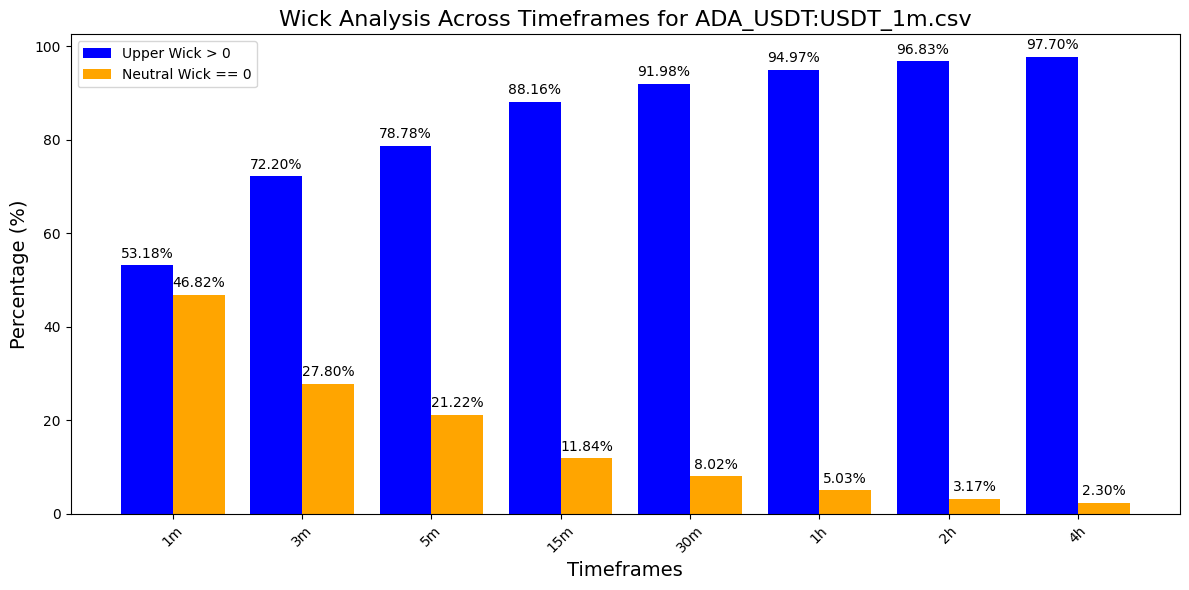

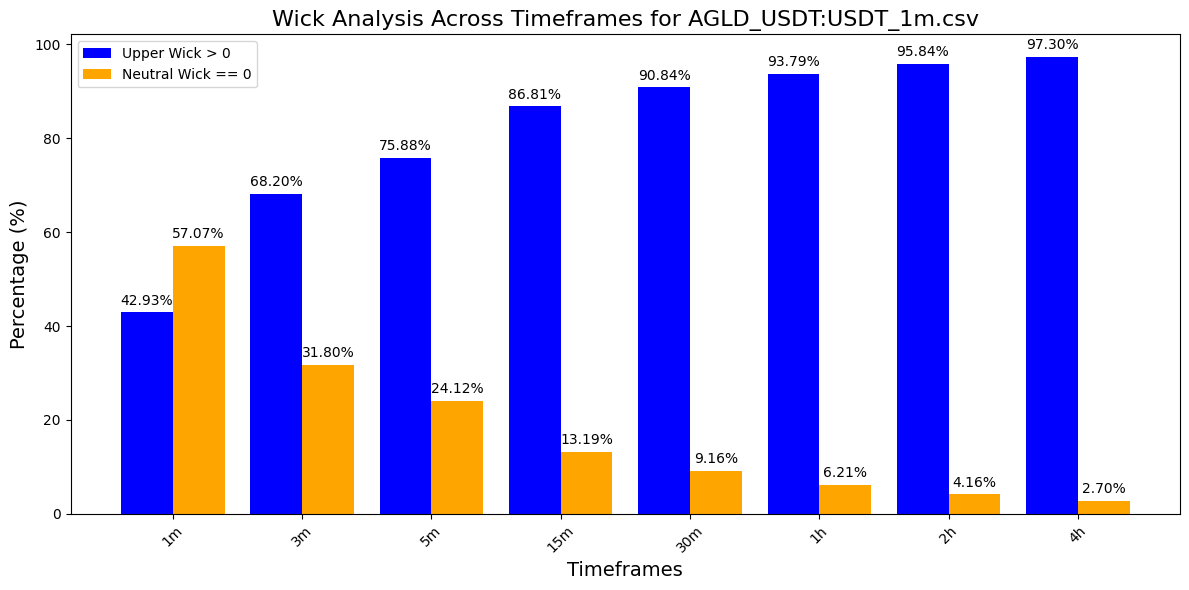

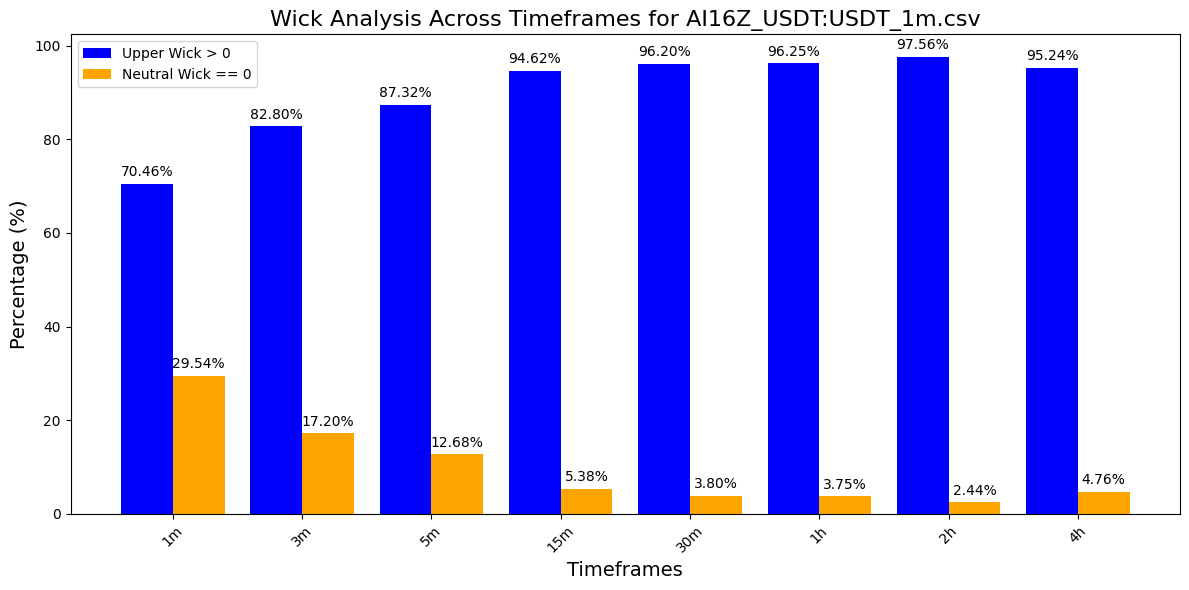

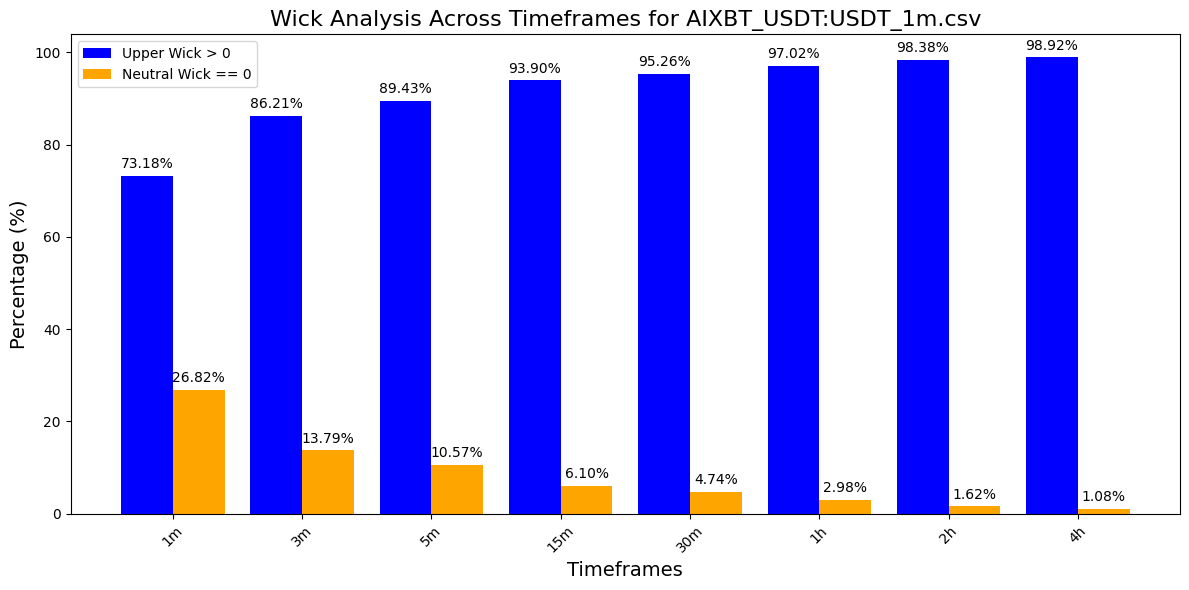

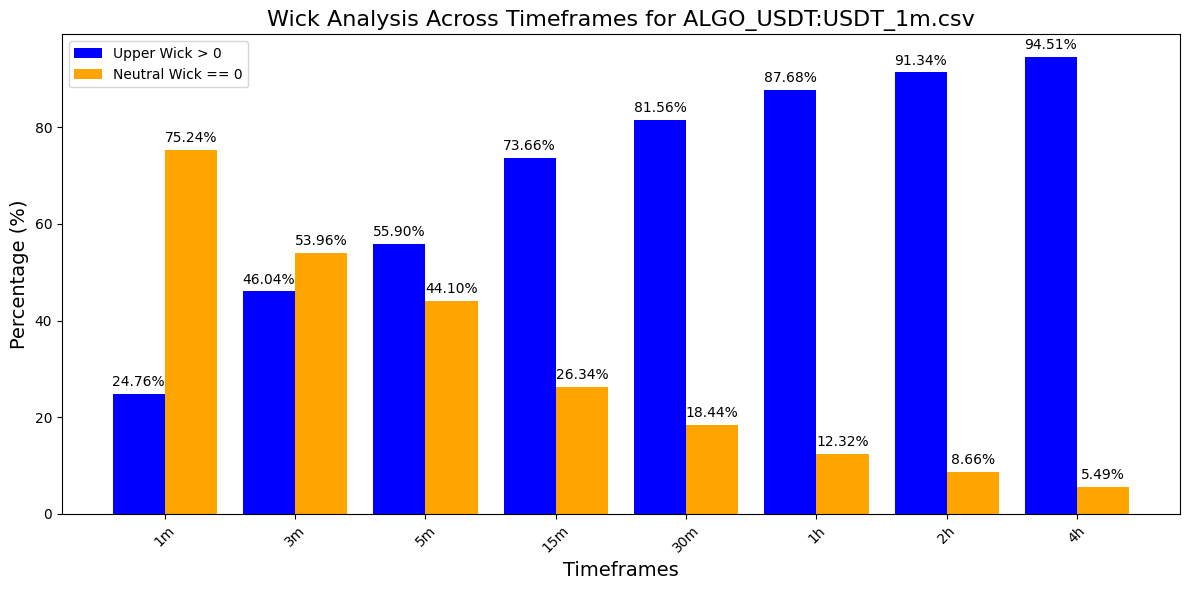

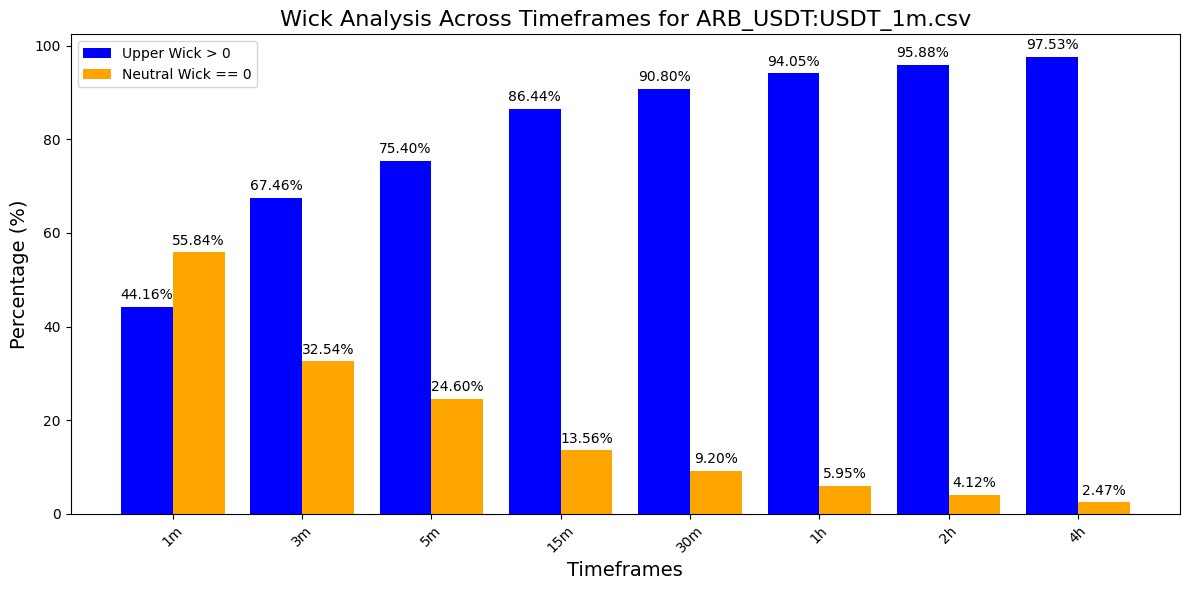

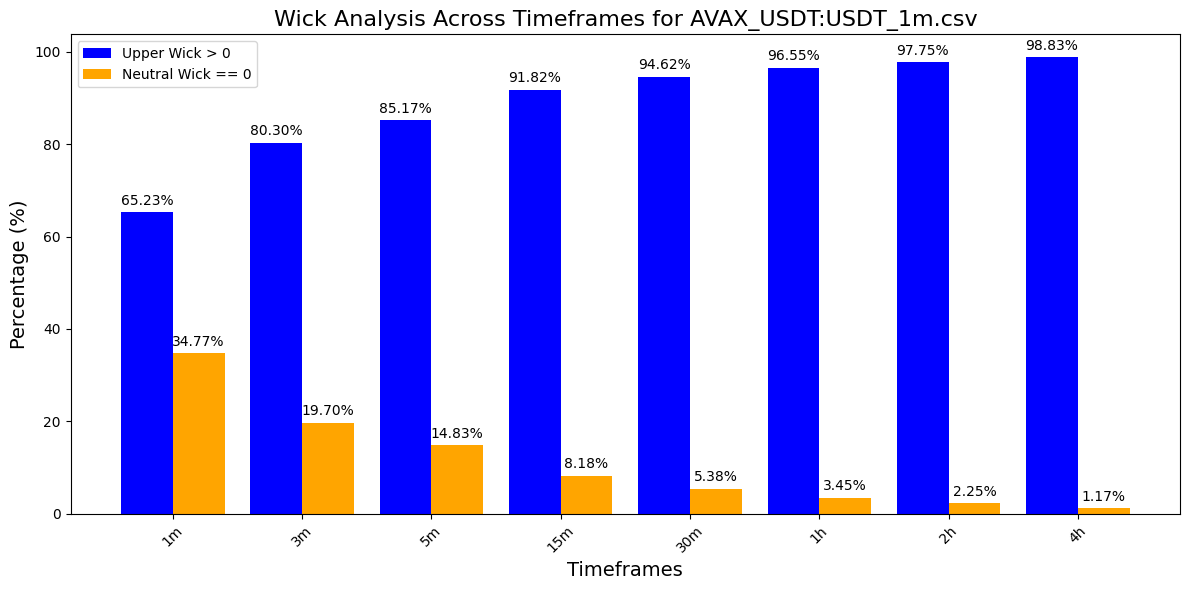

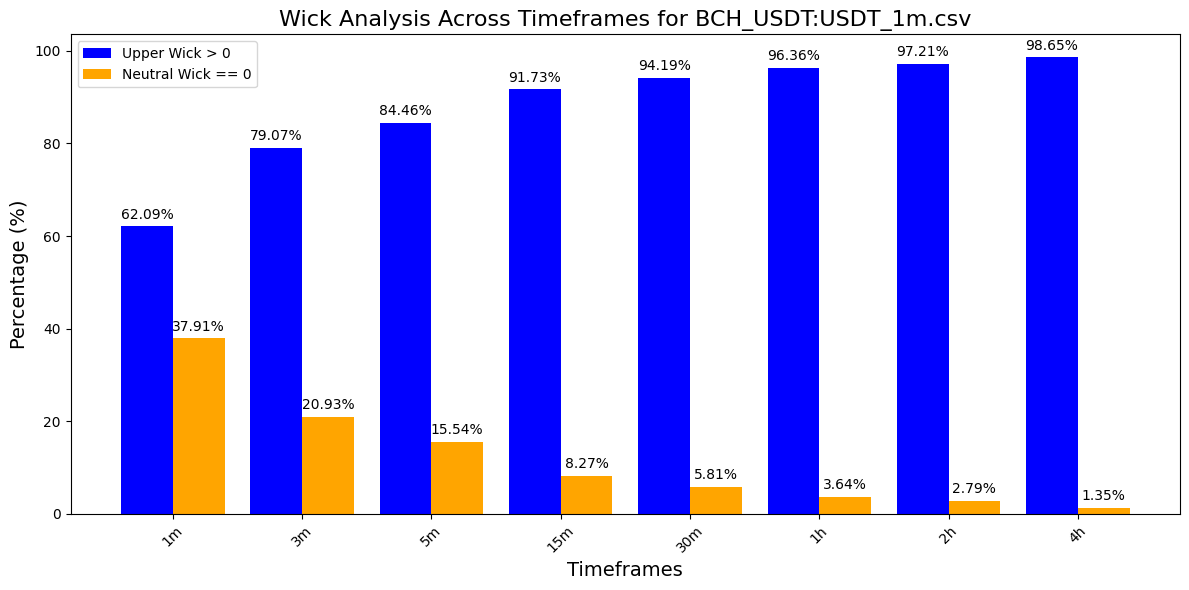

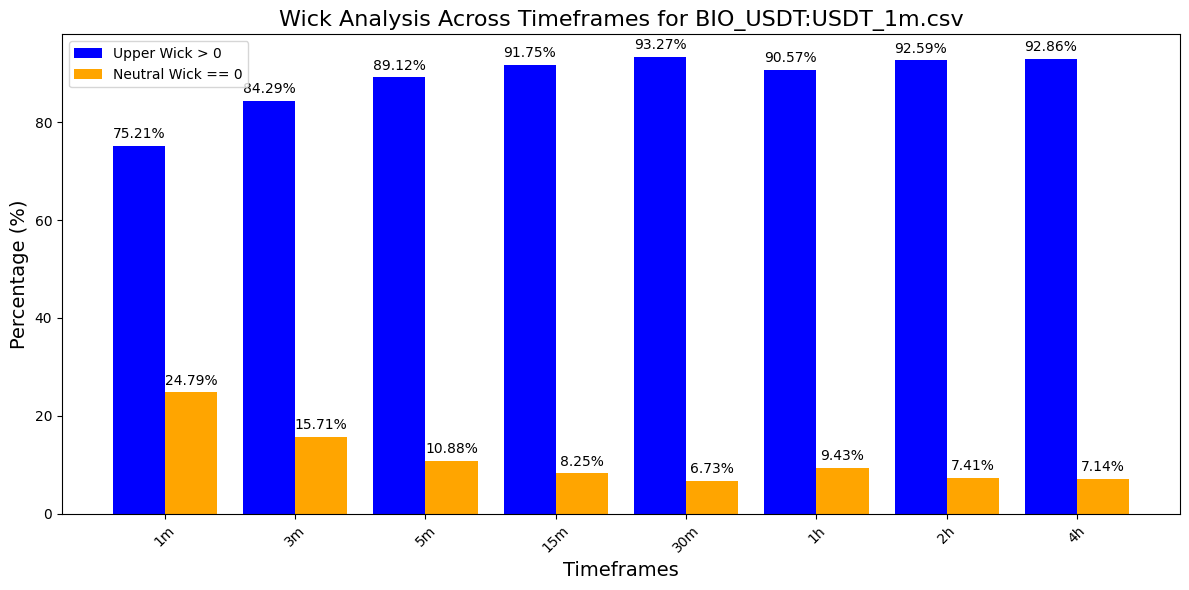

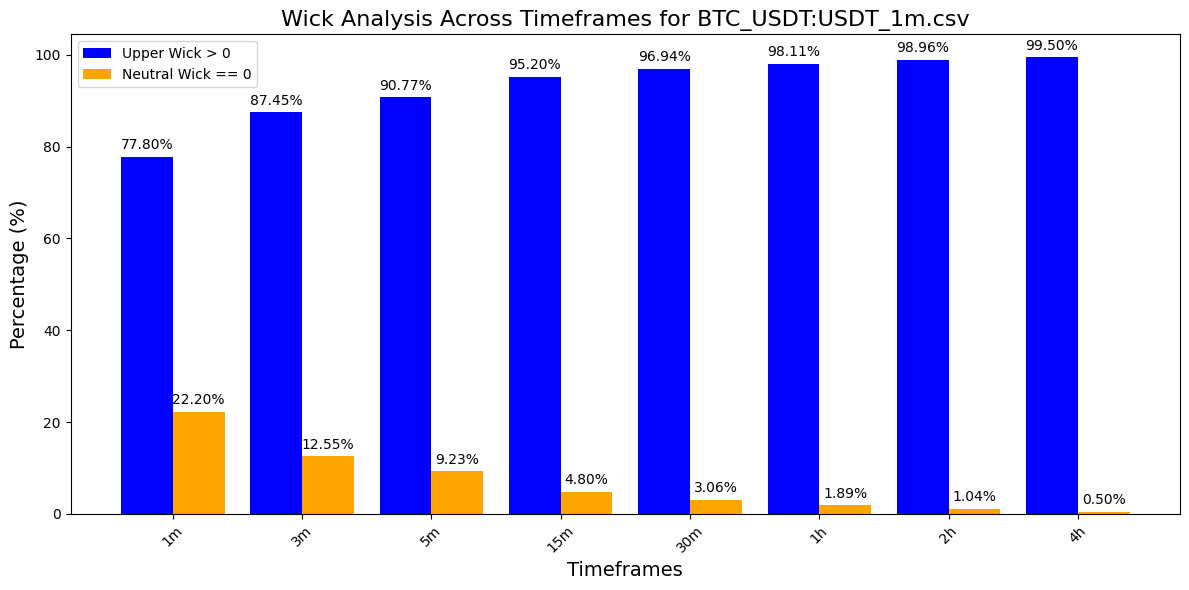

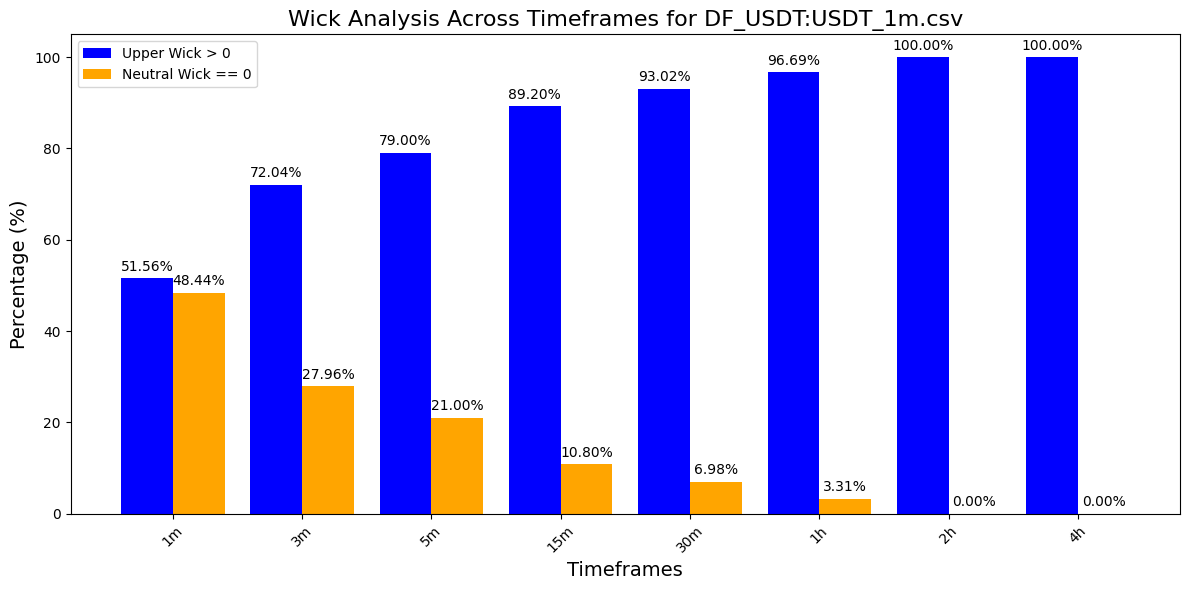

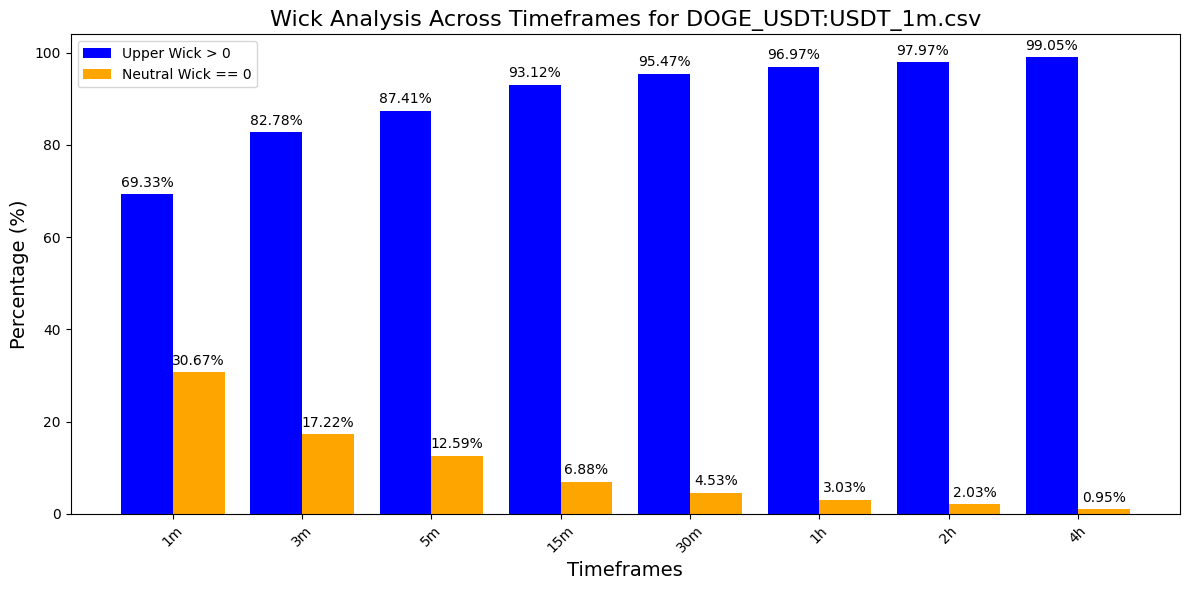

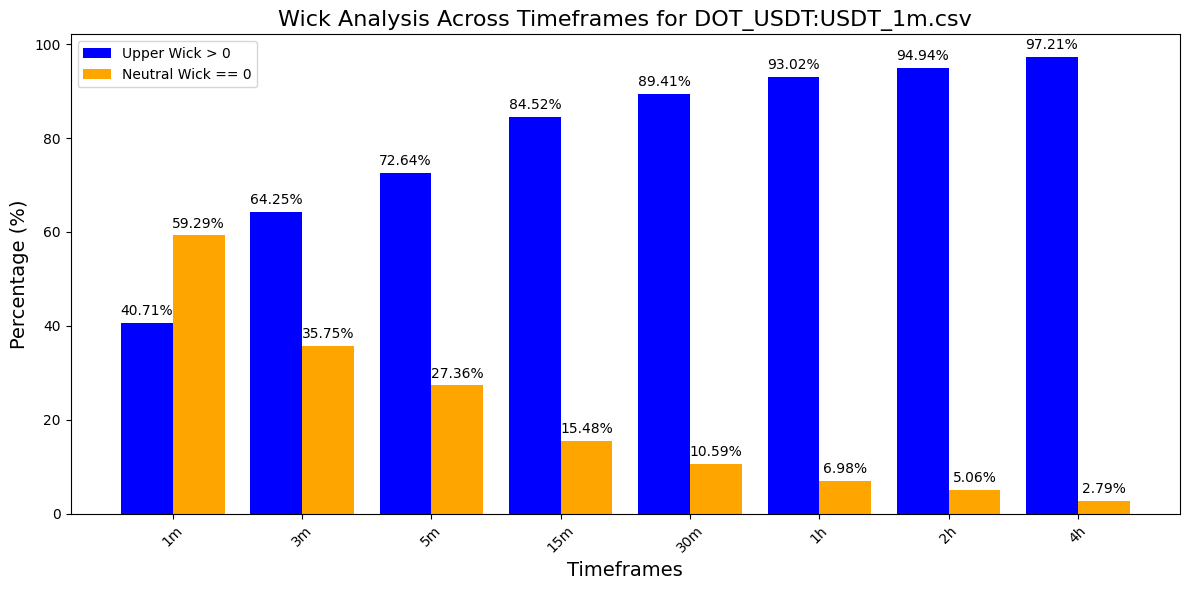

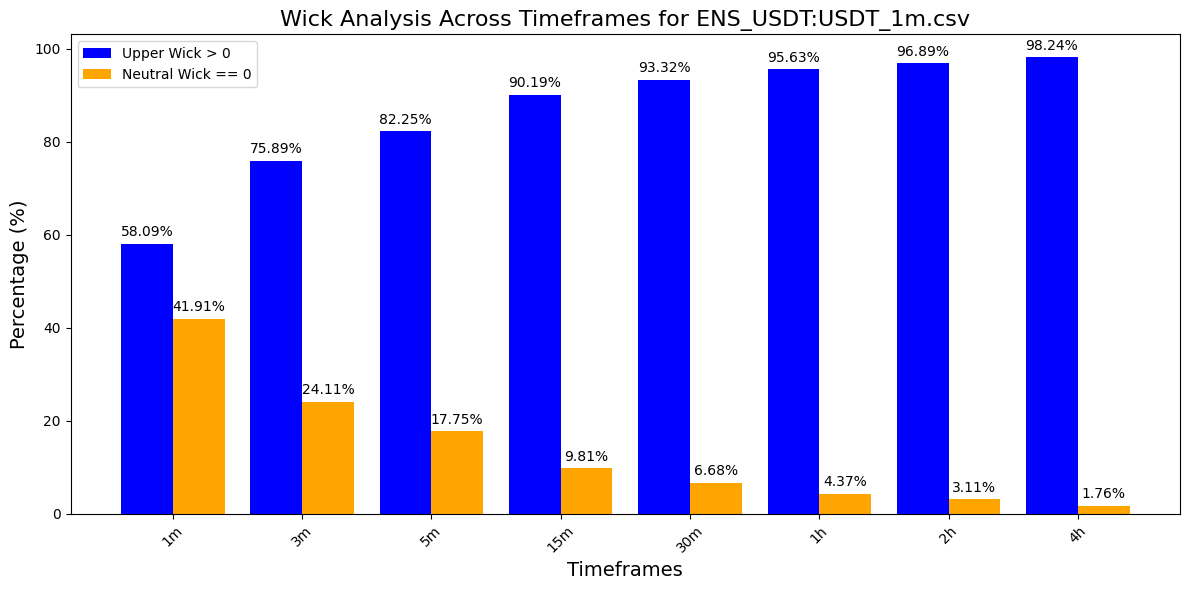

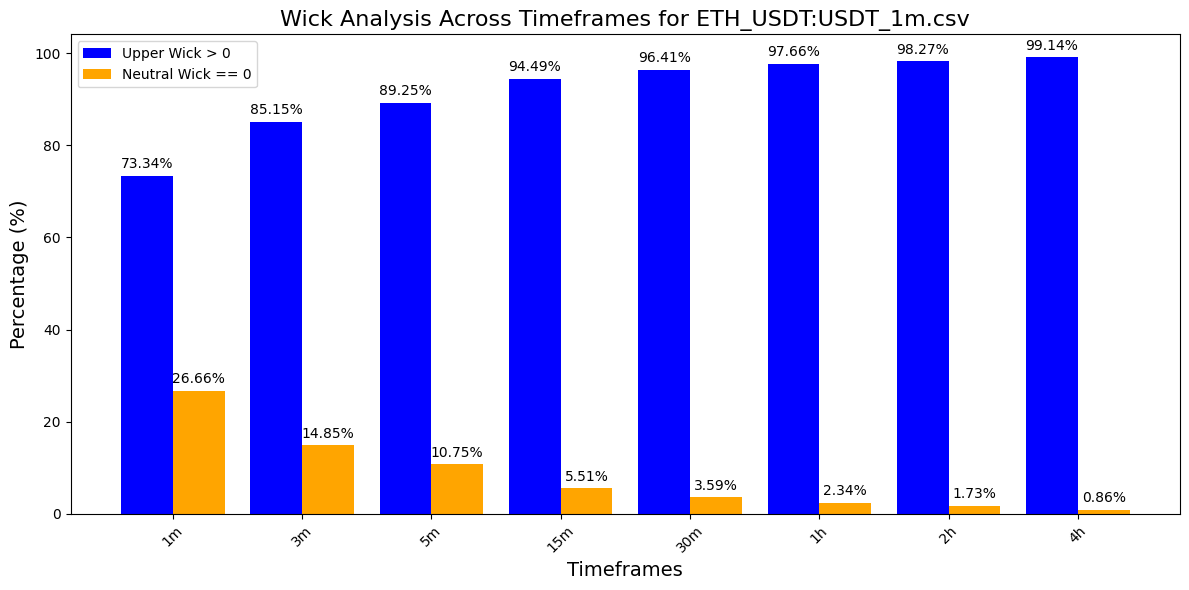

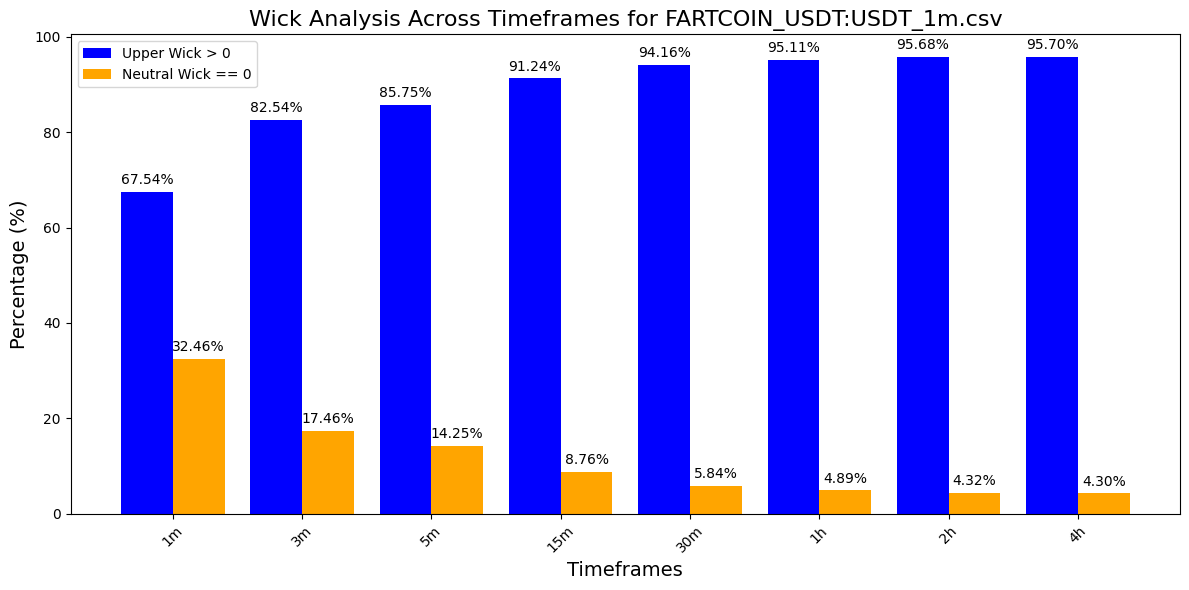

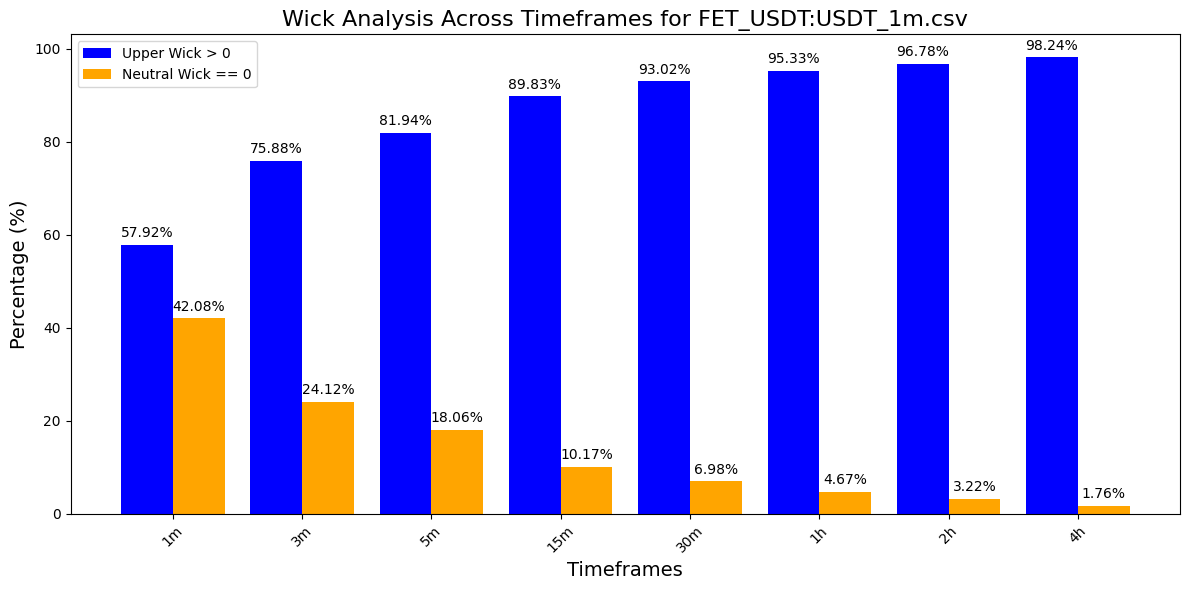

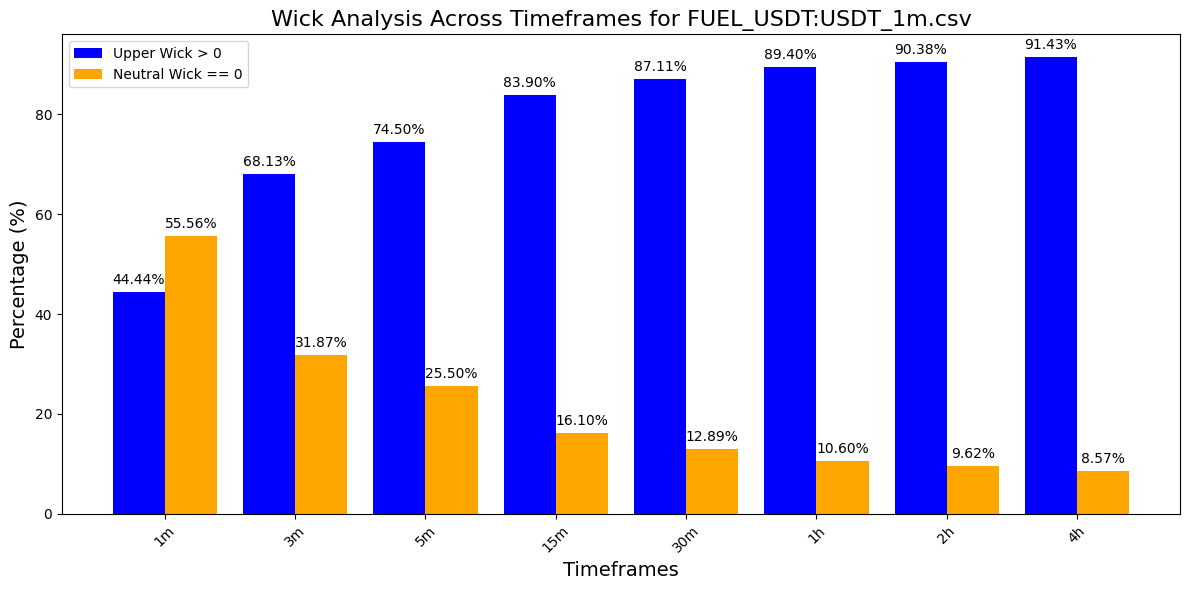

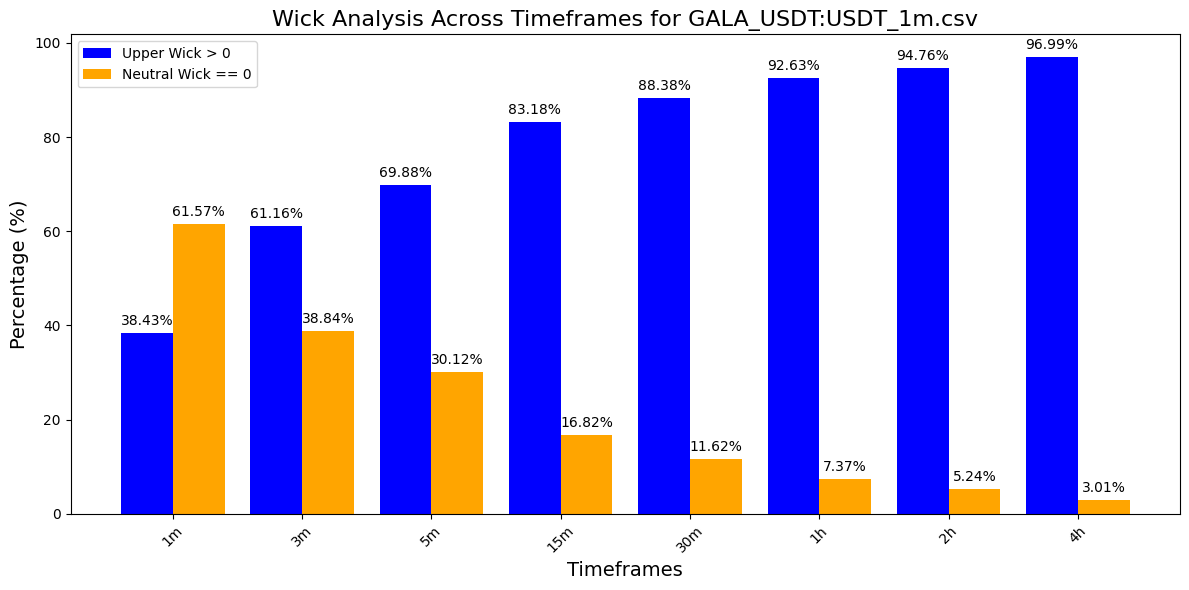

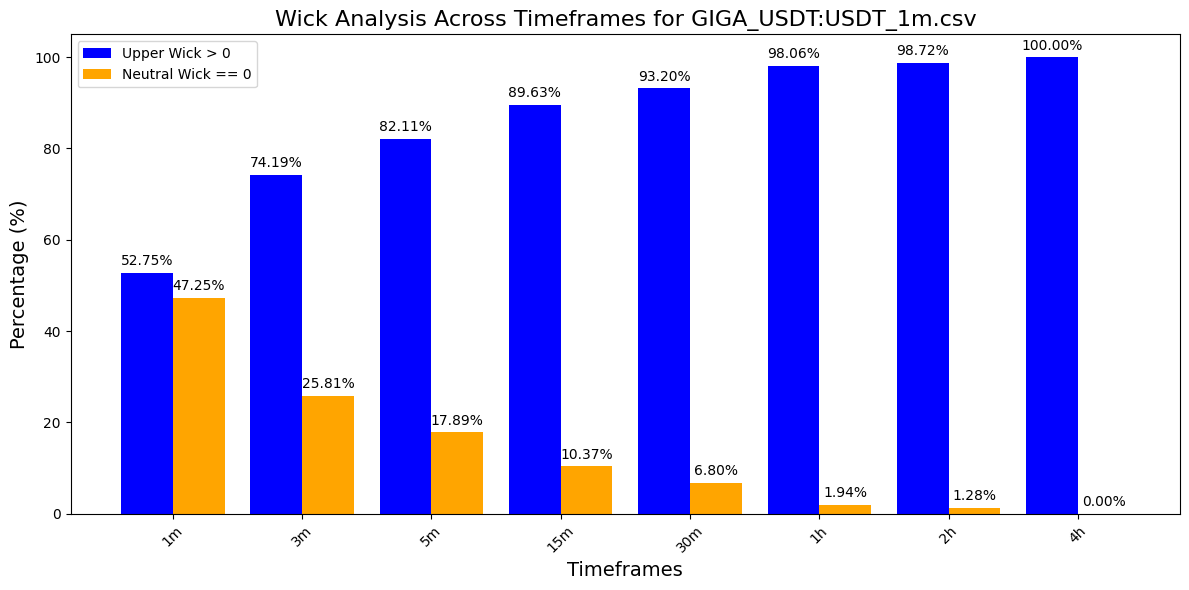

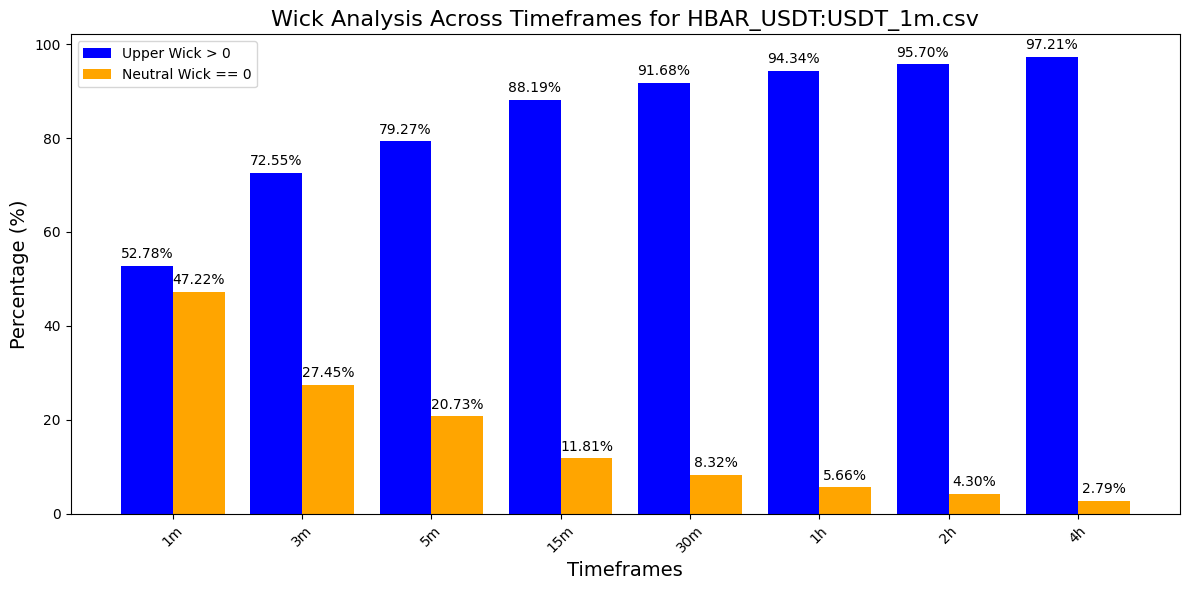

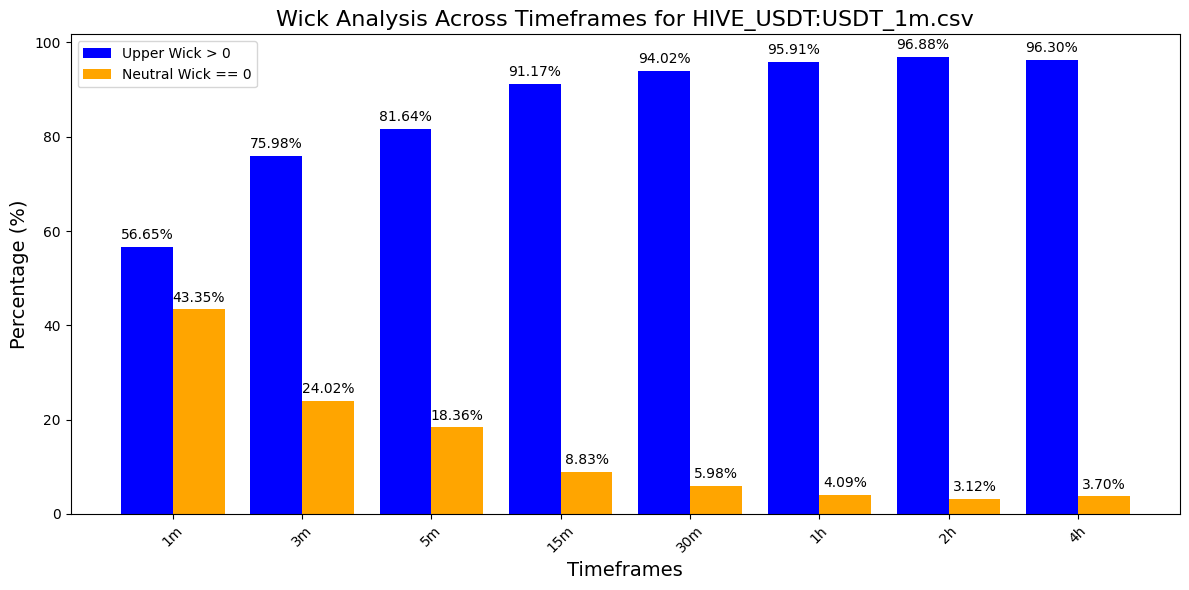

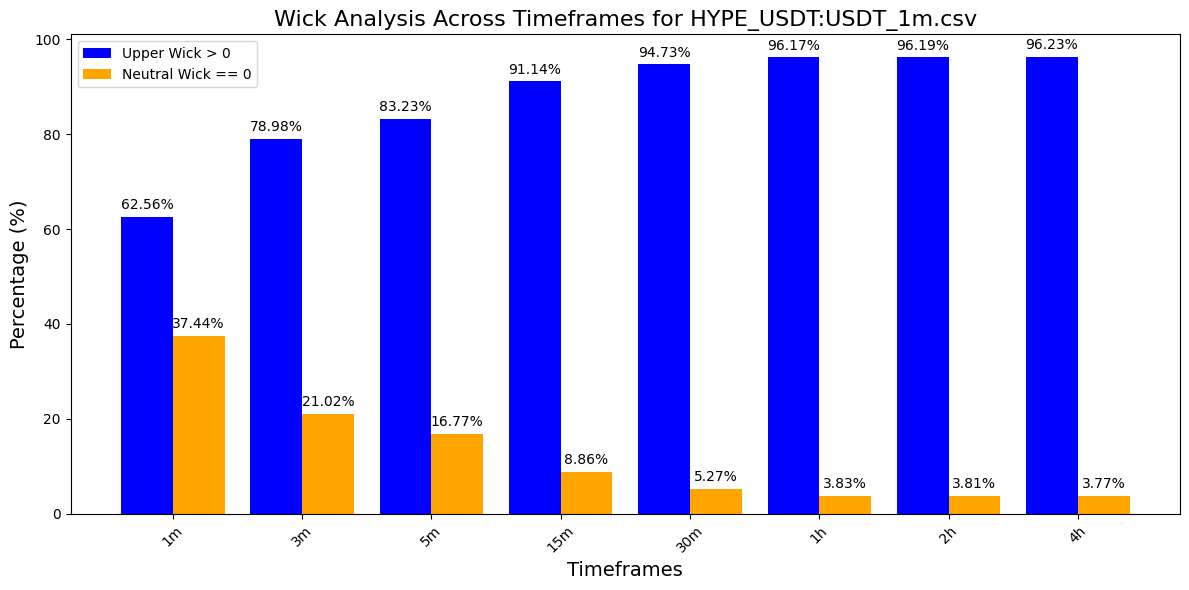

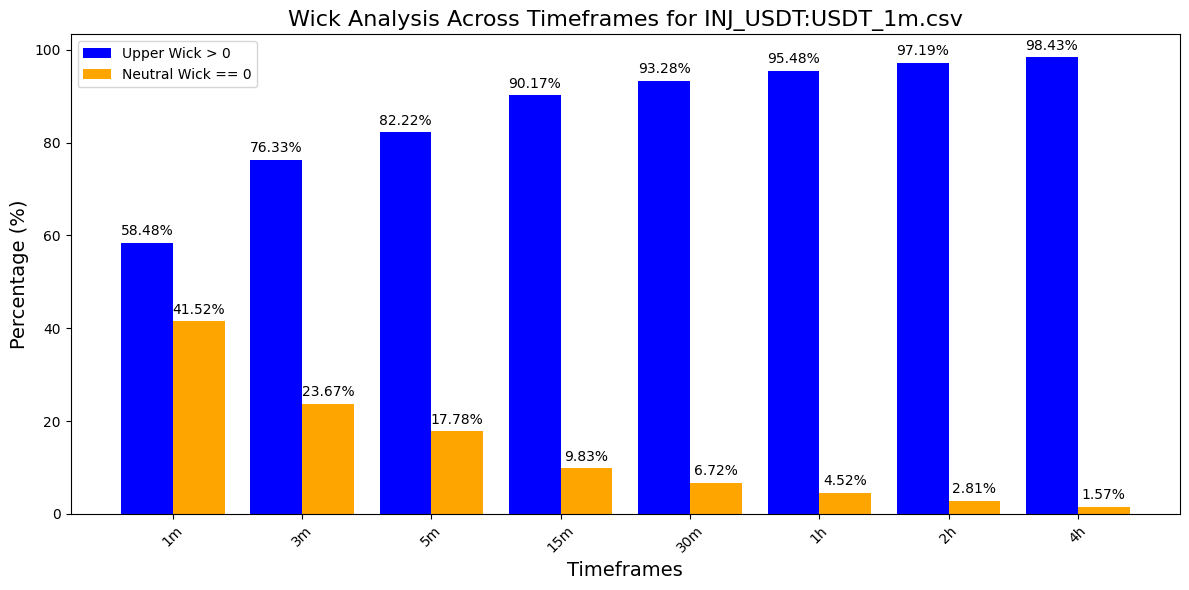

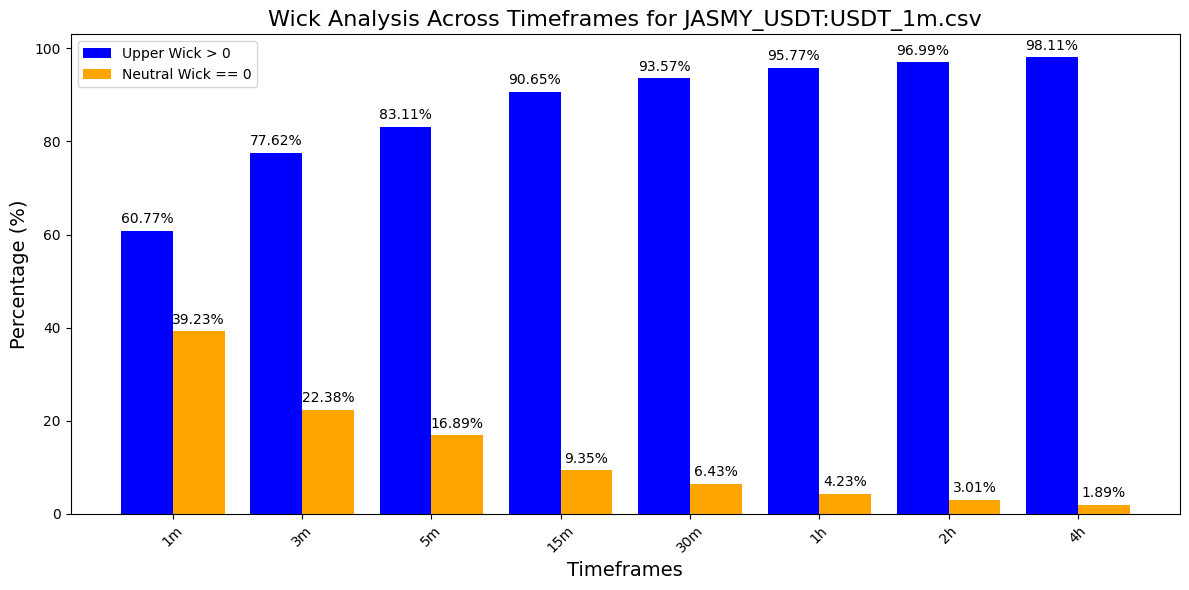

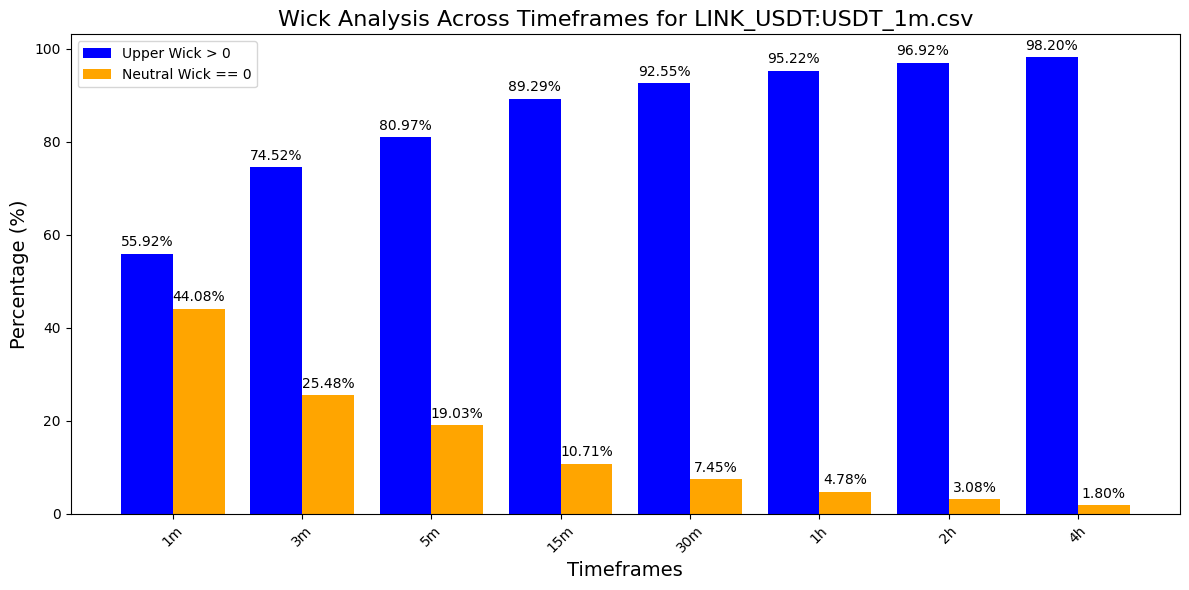

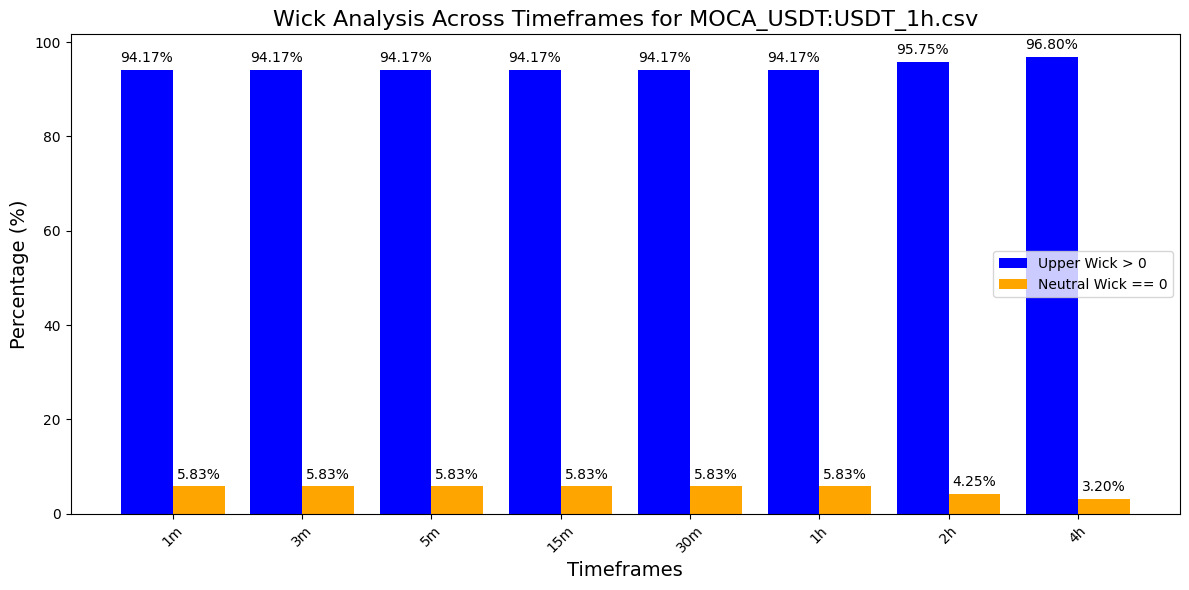

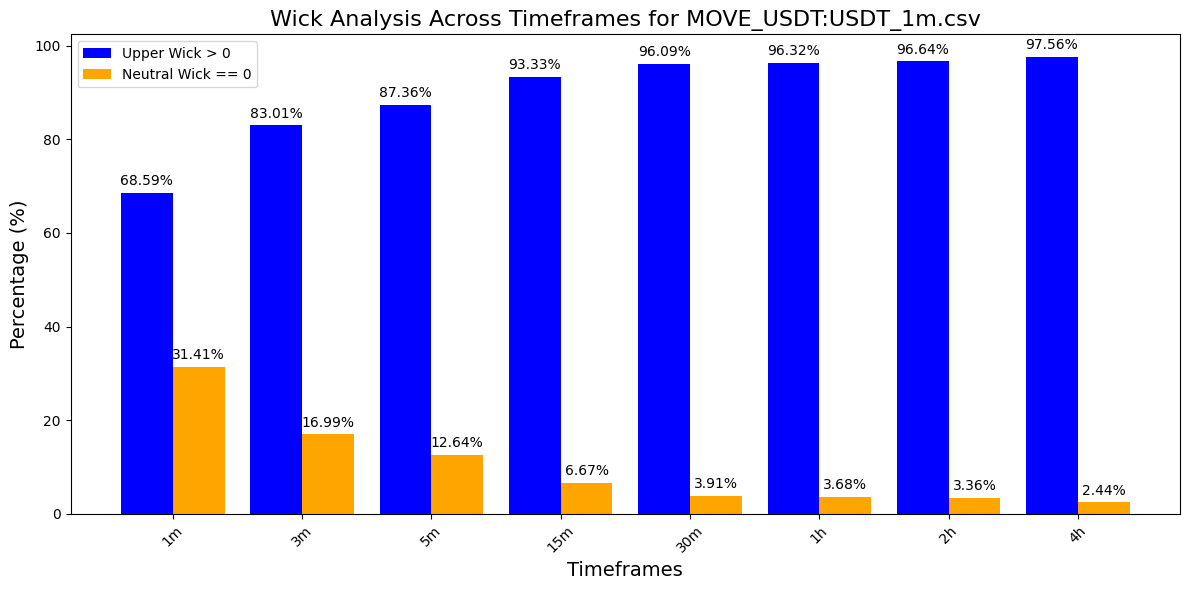

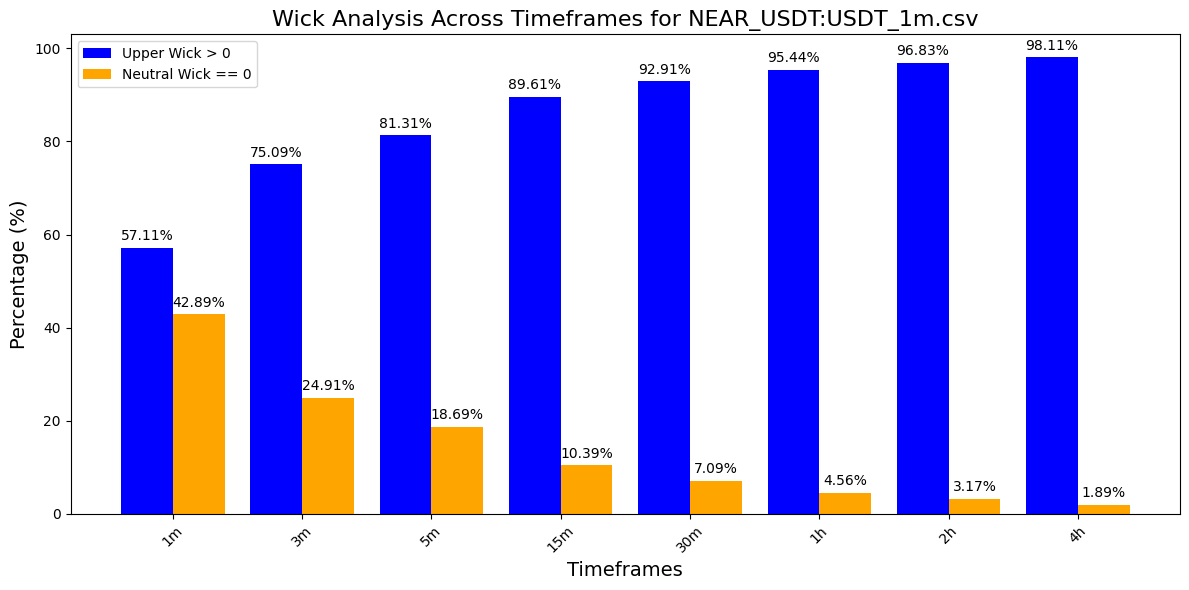

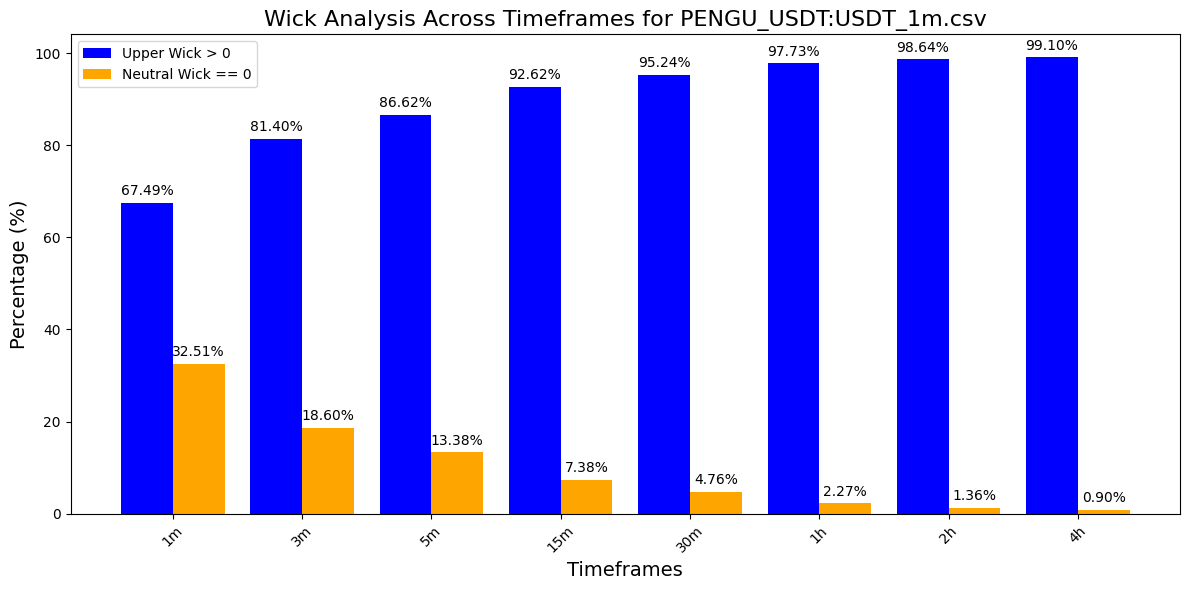

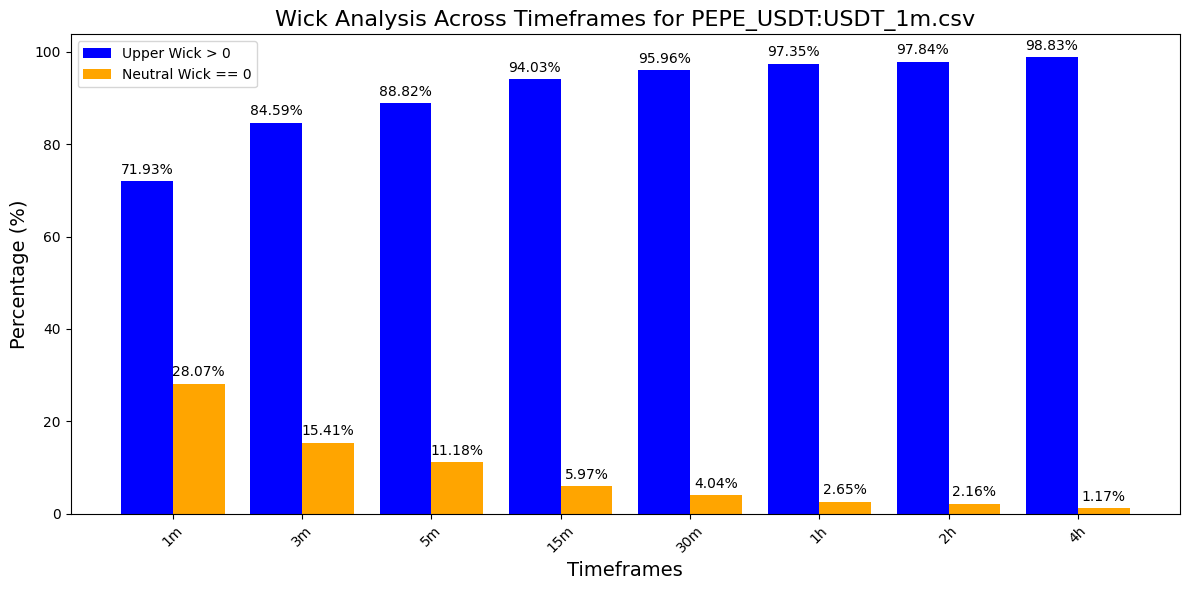

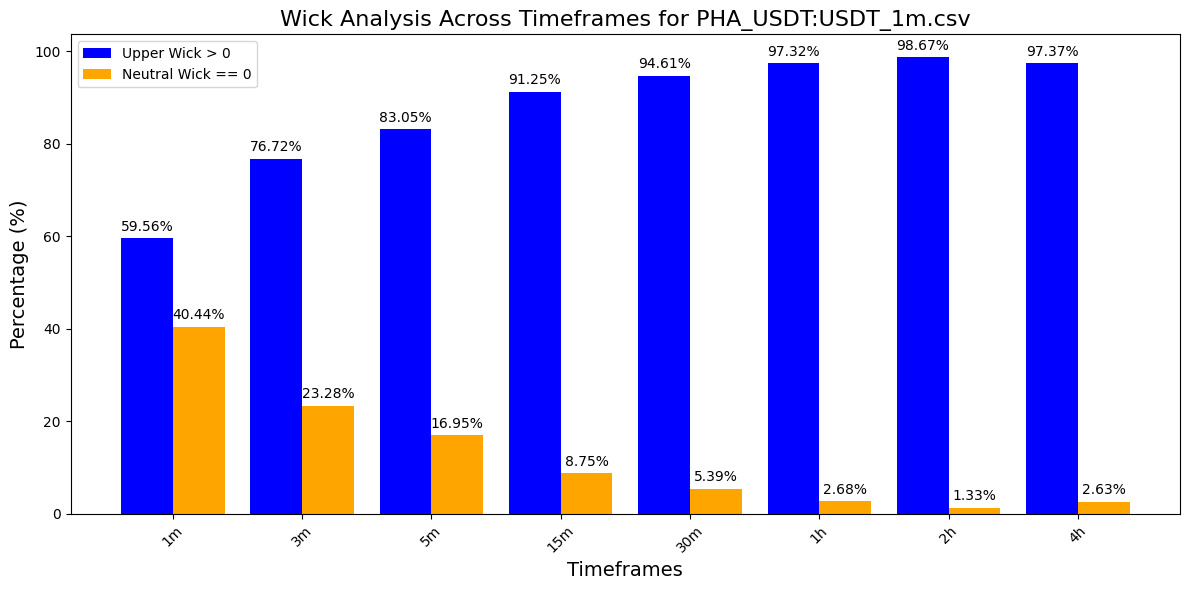

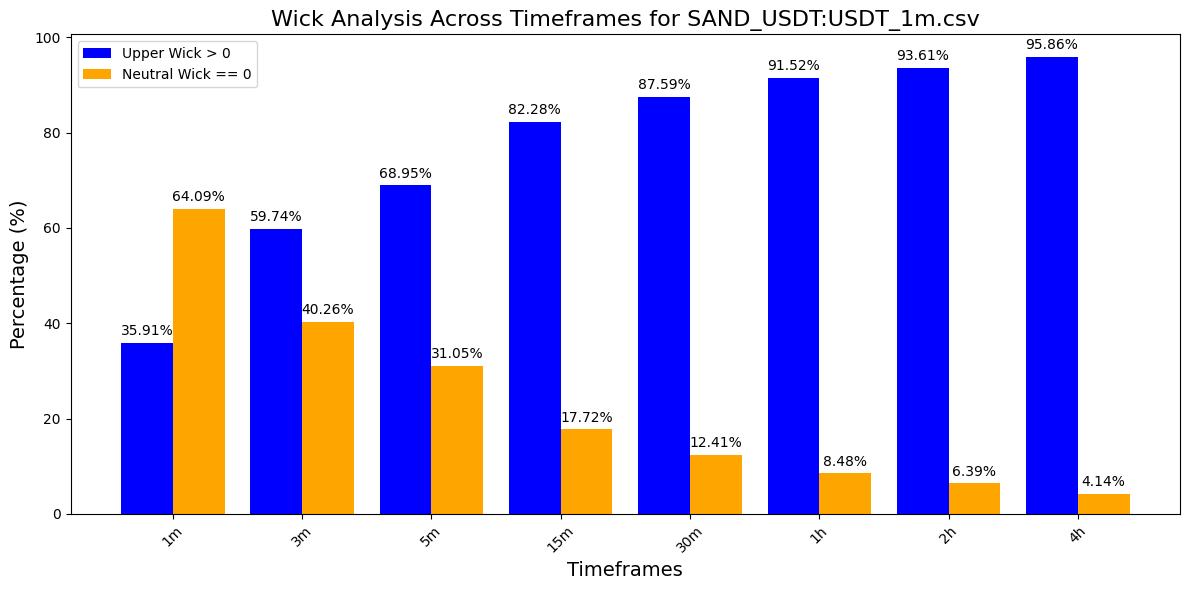

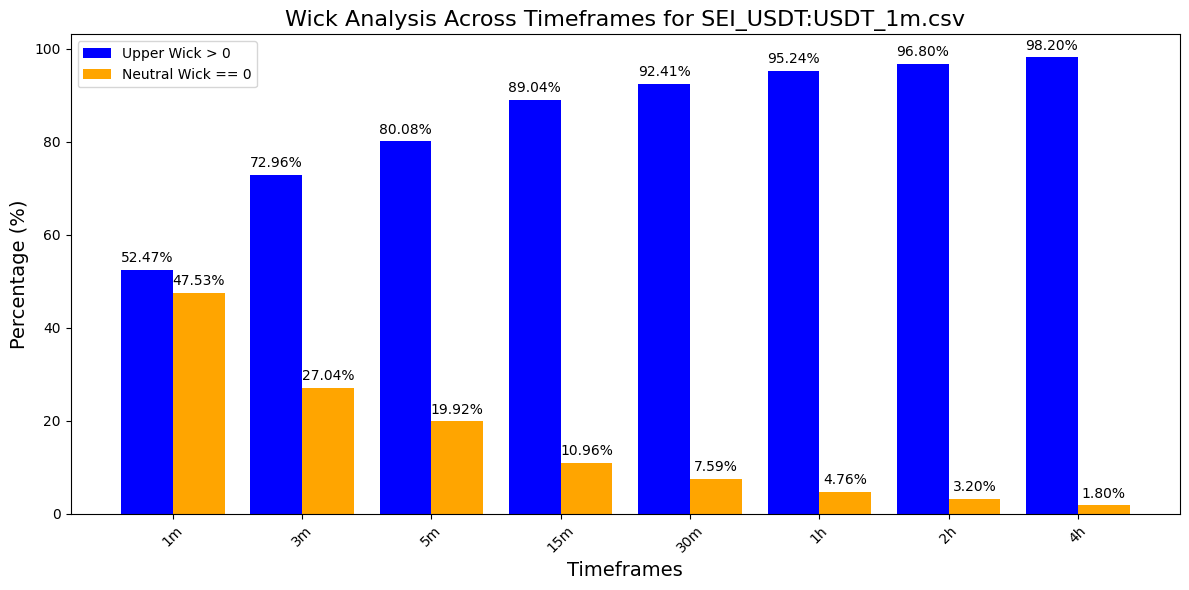

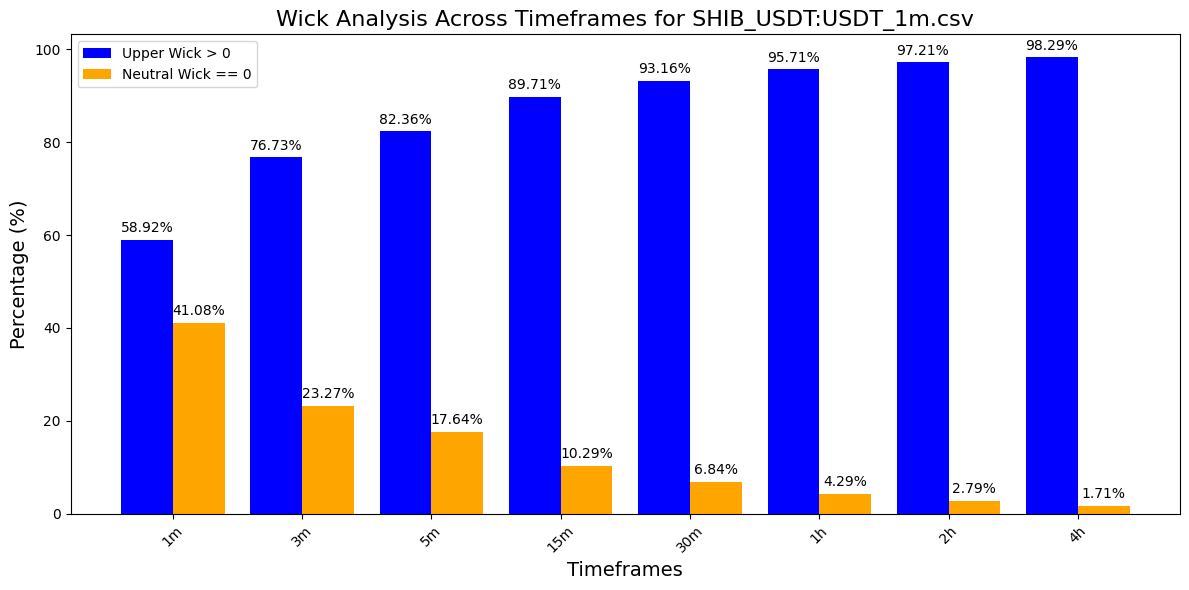

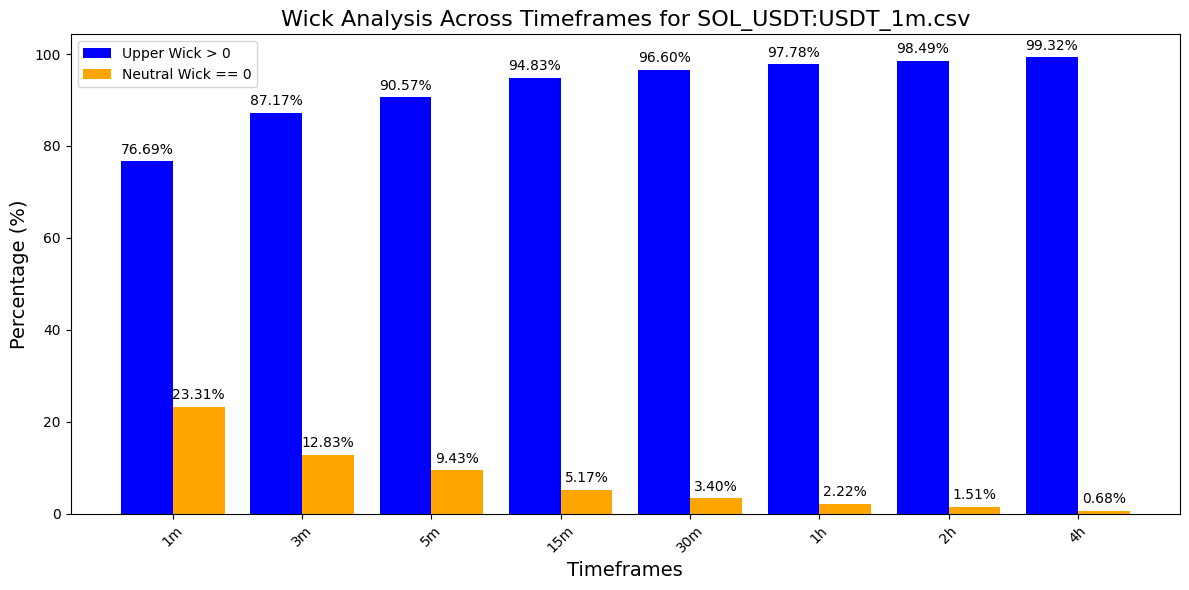

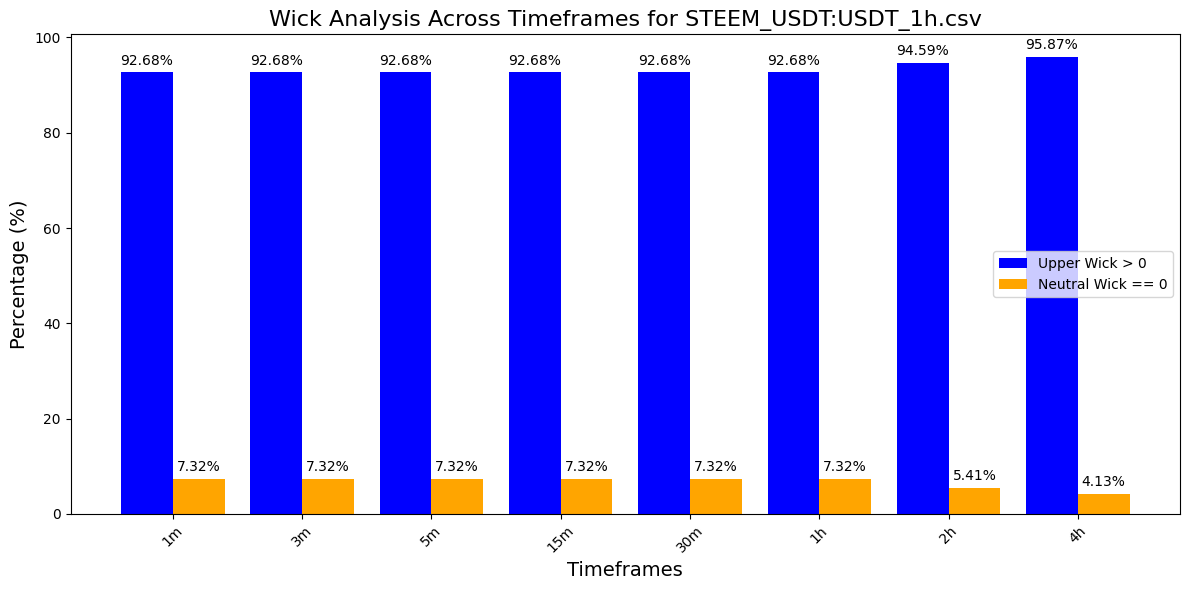

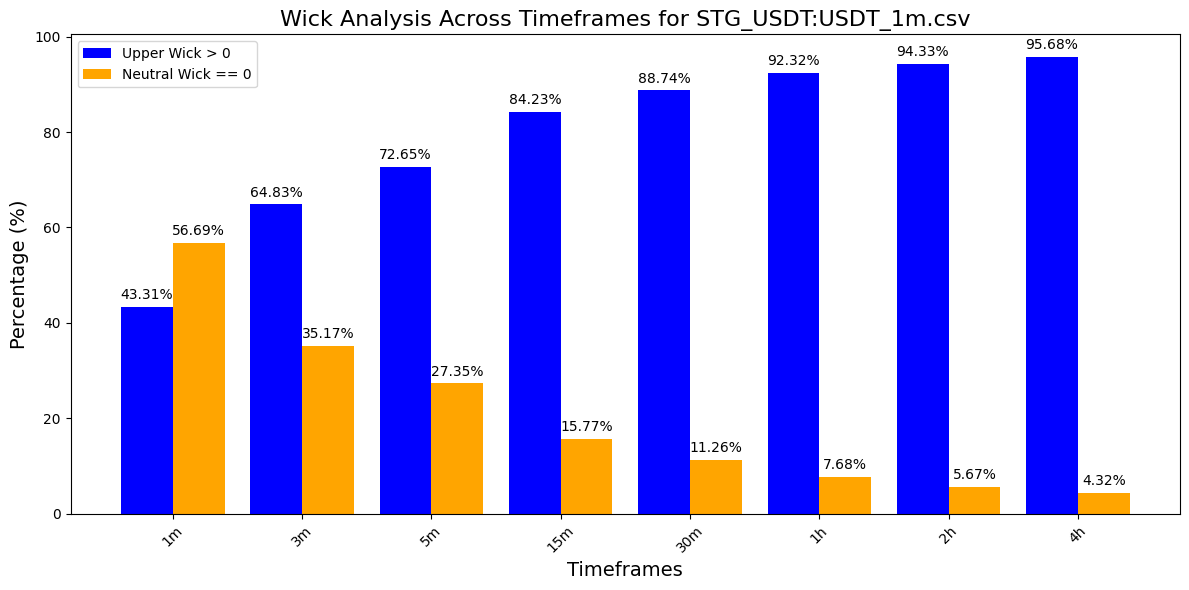

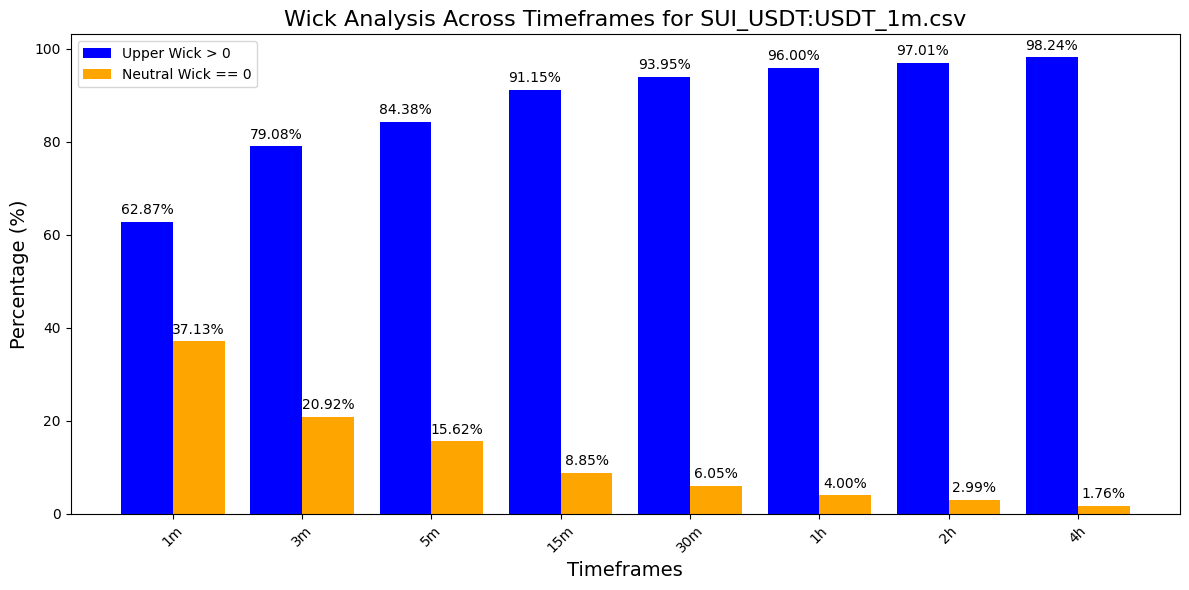

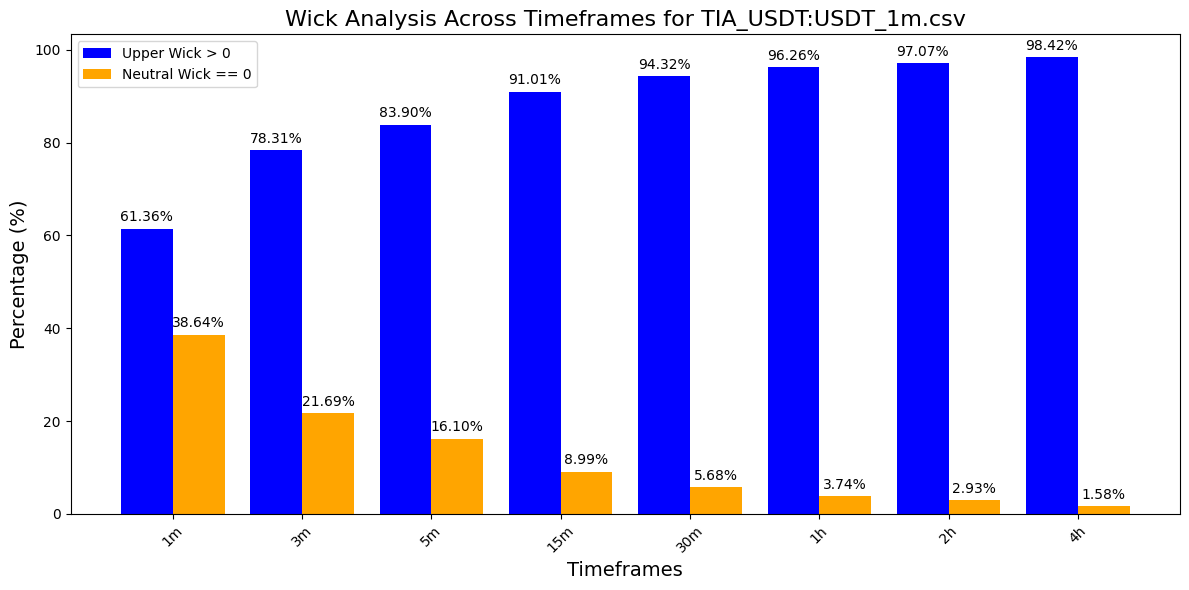

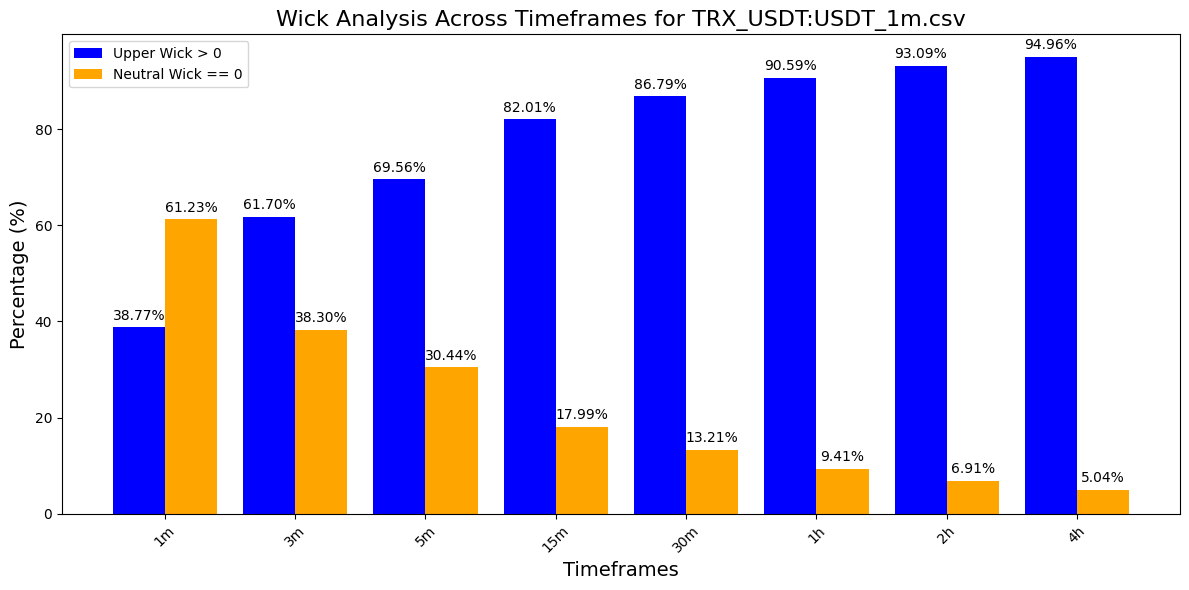

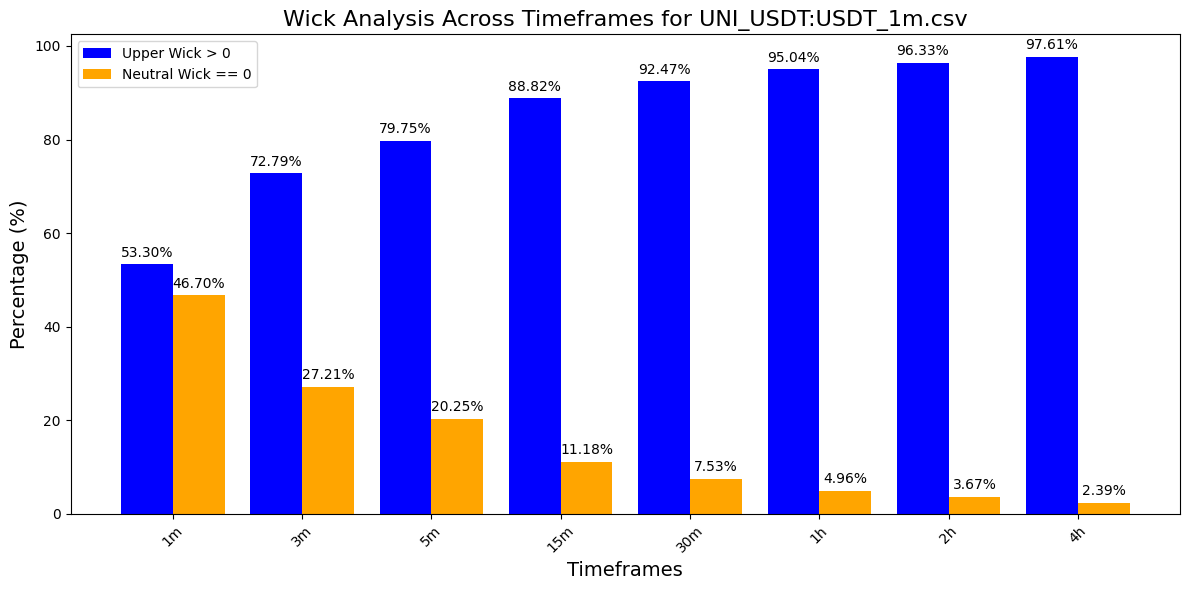

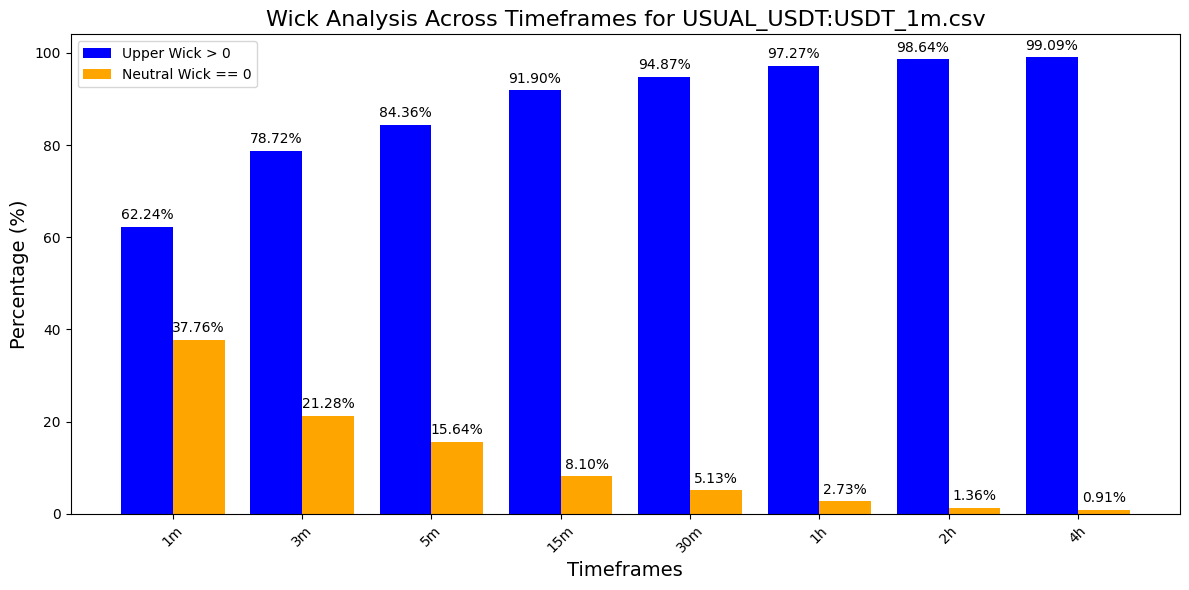

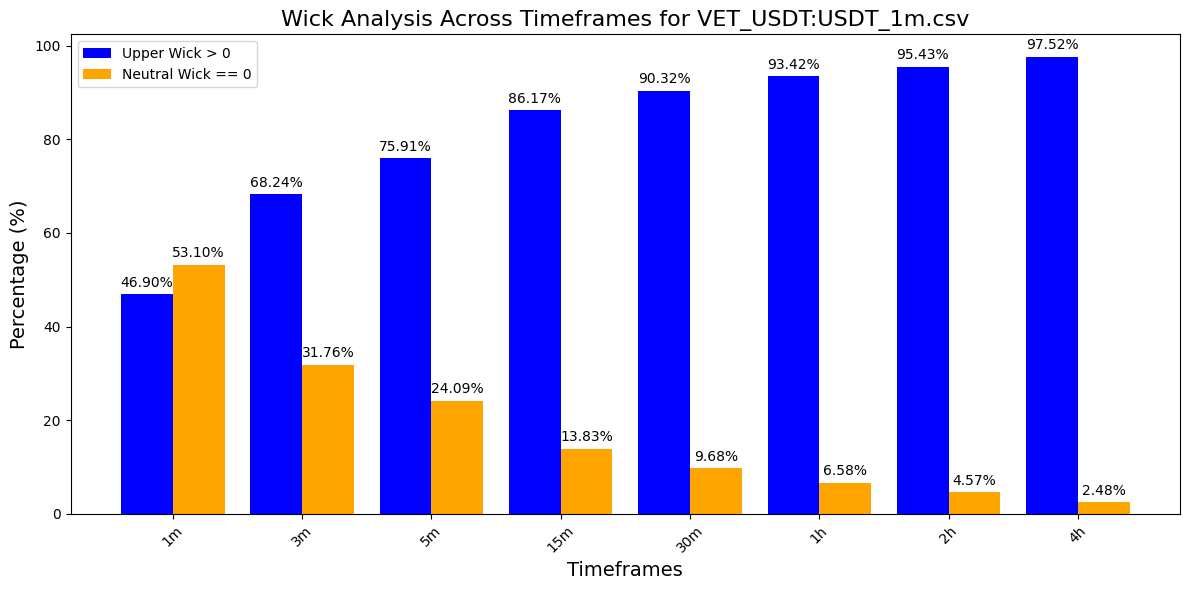

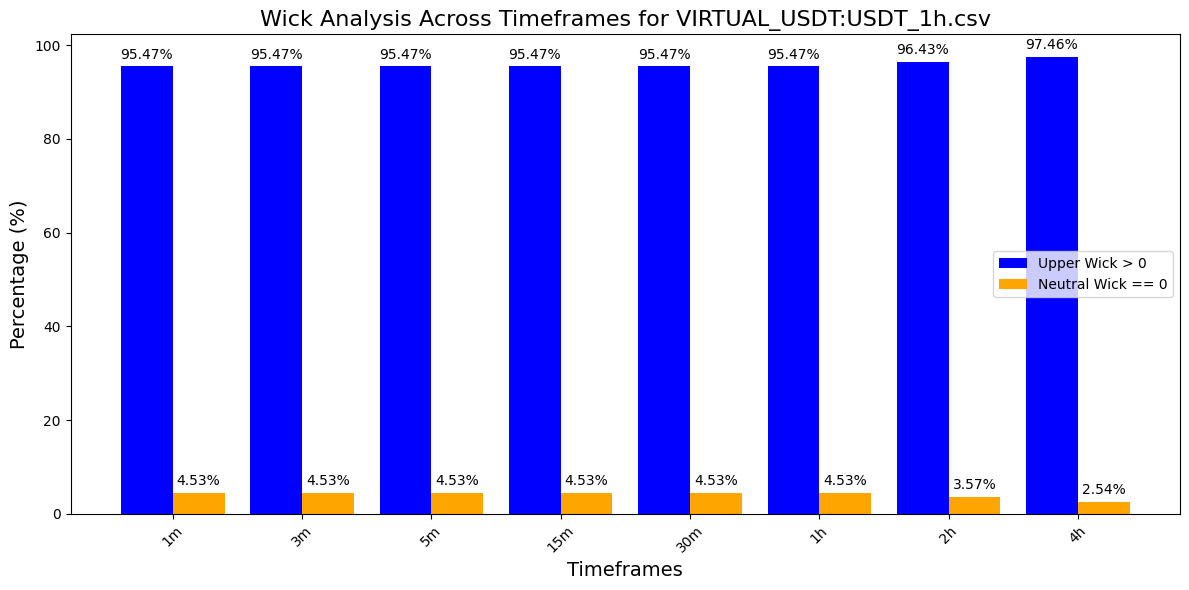

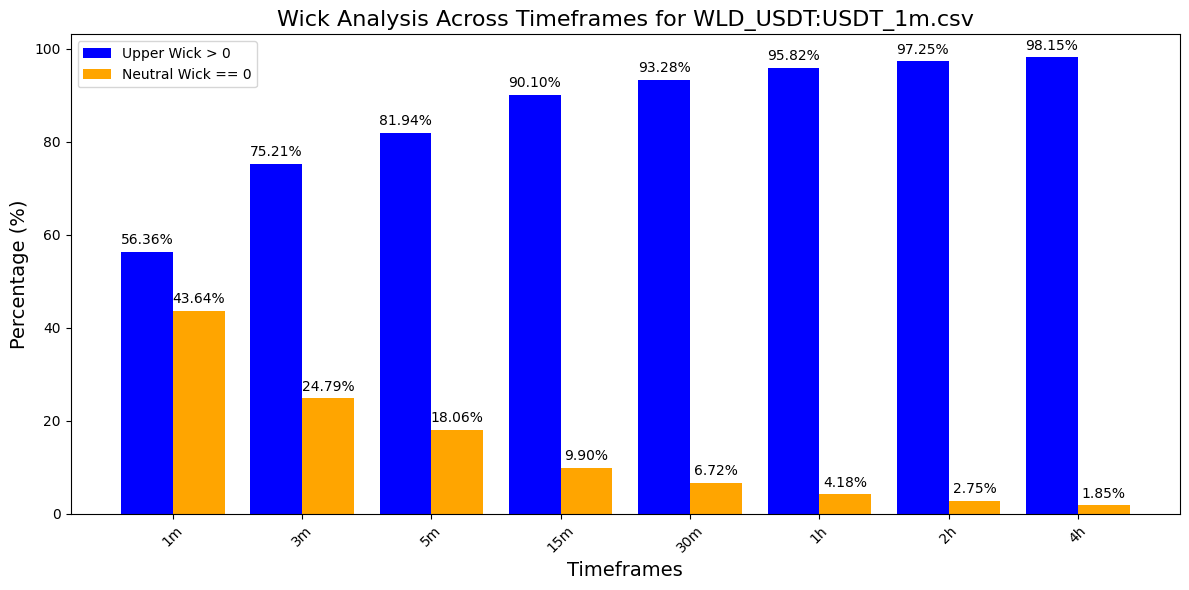

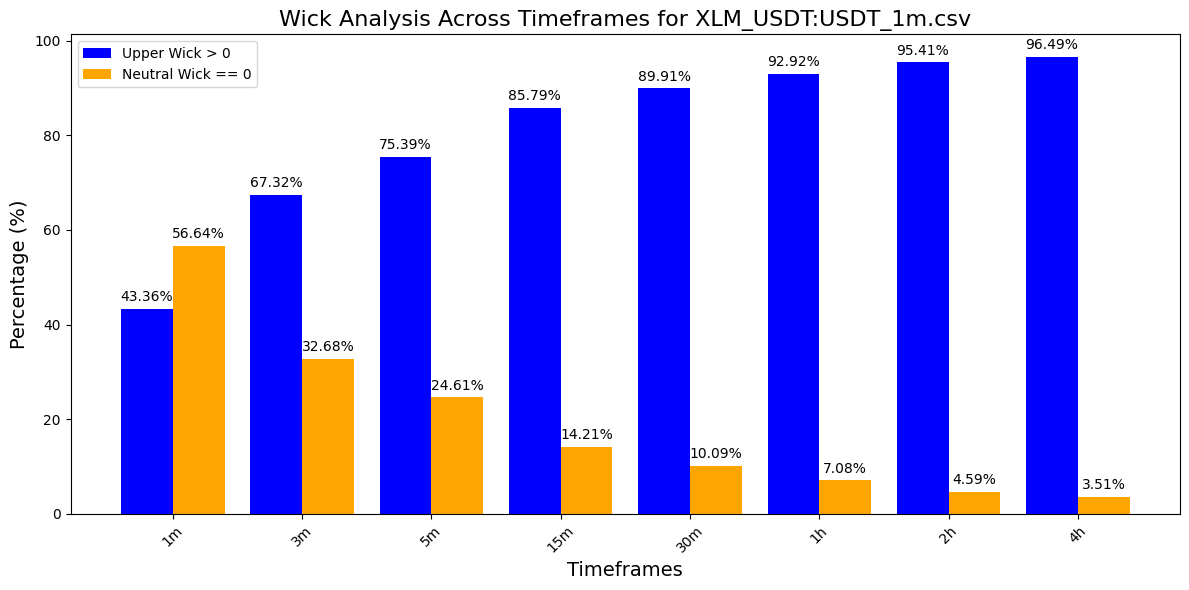

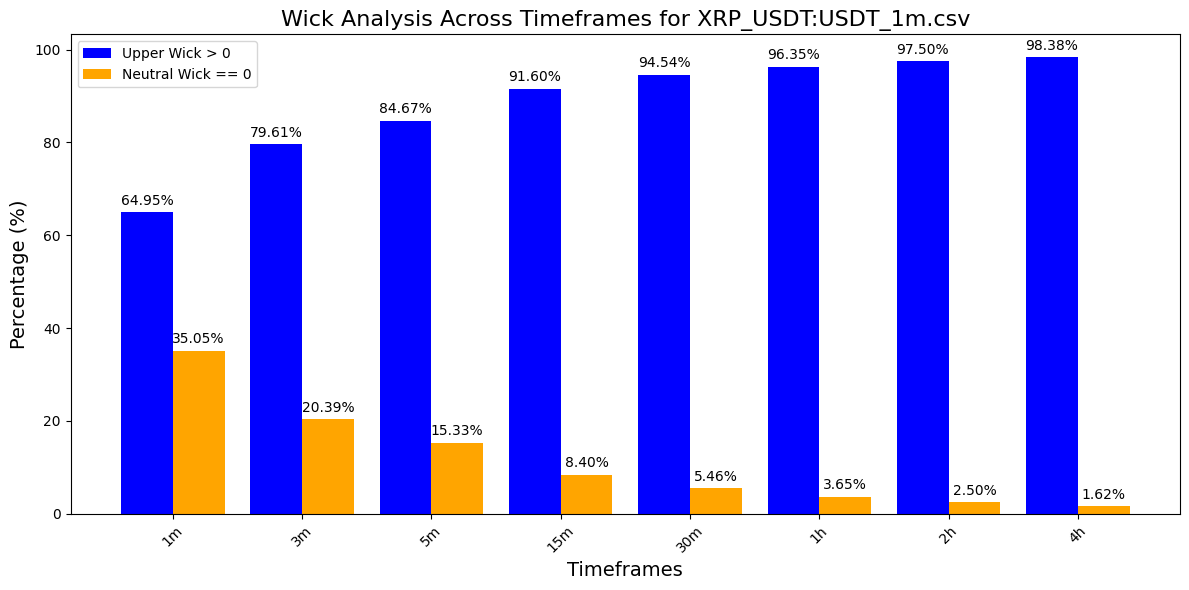

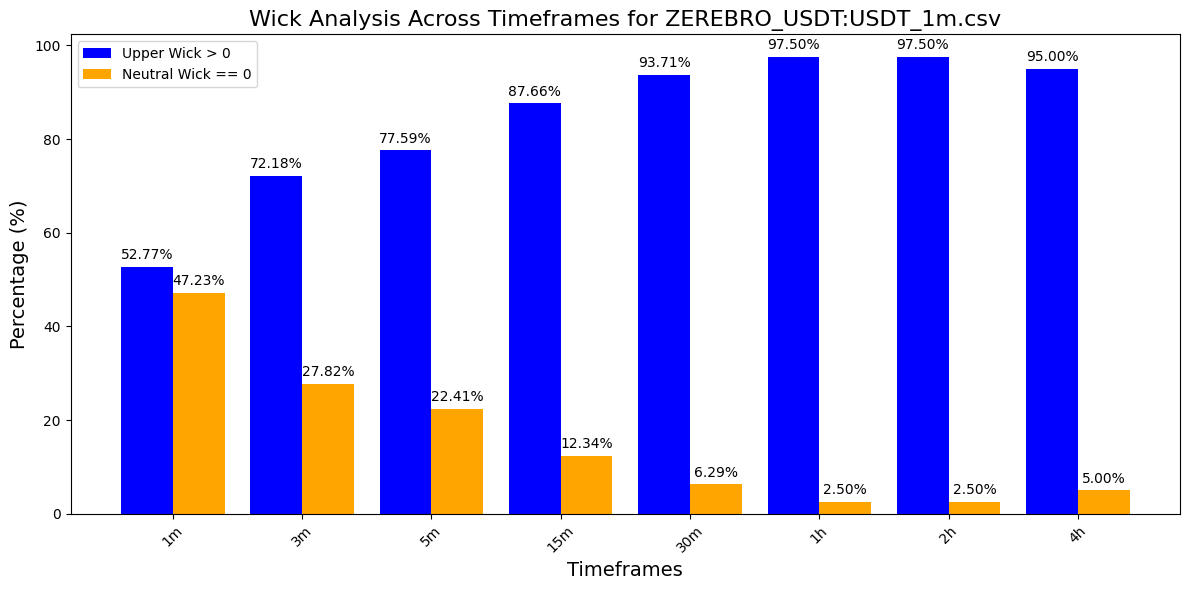

In [40]:
import natsort
import glob
import os 

PATH_SAVE = "/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/"


files_path = natsort.natsorted(glob.glob(os.path.join(PATH_SAVE, "*.csv"), recursive=False))
for file_path in files_path:


    path, filename = os.path.split(file_path)

    df = pd.read_csv(file_path, header=None)
    df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    missing = check_missing_timestamps(df, freq='1min')
    df.set_index('date', inplace=True)
    results = calculate_wick_statistics(df, timeframe_resampling_map)
    plot_wick_statistics(results, filename)

In [32]:
df['upper_wick_pct'] = ((df['high'] - df['close']) / df['close']) * 100

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot the distribution of upper_wick_pct
plt.figure(figsize=(10, 6))
sns.histplot(df['upper_wick_pct'], kde=True, color='skyblue')
plt.title('Distribution of Upper Wick Percentage', fontsize=16)
plt.xlabel('Upper Wick Percentage (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df['upper_wick'][df['close'] <  df['open']]

In [ ]:
import plotly.graph_objects as go
# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',  # Green for price increase
    decreasing_line_color='red',    # Red for price decrease
)])
# Customize layout
fig.update_layout(
    title='Candlestick Chart of Price',
    xaxis_title='Date',
    yaxis_title='Price (USDT)',
    template='plotly_dark',  # Set a dark theme for the plot
    xaxis_rangeslider_visible=False  # Optionally hide the range slider
)
# Show the plot
fig.show()